## Pseudo-código Classifier

### 1° passo: recebe uma "internal workorder" que específica a quantidade, cor, tamanho, sabor e embalagem a ser produzido

In [73]:
import pandas as pd
import math
import numpy as np
import simpy
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import time

start = time.time()

## Ler os dados fornecidos

In [74]:
path = 'D:/Programas/UFSC/2020_OR_Analytics_Student_Team_Competition/1. Base de Dados do Problema/Original/'

#Notebook Vitor: 'D:/Programas/UFSC/2020_OR_Analytics_Student_Team_Competition/Base de Dados do Problema/Original/'
#Notebook Luccas: 'C:/Users/lucca/Desktop/OR & Analytics 2020/Dados/'

#IMPORTANDO E TRATANDO OS DADOS

workorder = pd.read_csv(path+'Workorder Example.csv',decimal=".")
workorder['Color'] = workorder['Color'].str.title()
workorder['Plant Id'] = workorder['Plant Id'].replace({'COLUMBUSOH': 'Columbus, OH', 'DETROITMI': 'Detroit, MI', 'SPRINGFIELDMO': 'Springfield, MO', 'GREENBAYWE': 'Green Bay, WI', 'OMAHANE': 'Omaha, NE'}, regex = True)
workorder['Stage'] = 0
workorder['Produzido'] = ''
#
RMI = pd.read_csv(path+'RMI Inventory Level.csv')
RMI['num'] = RMI['RMI Drum'].apply(lambda x: int(x.split(sep='RMI DRUM')[-1])-1)
#
classifier_rates= pd.read_csv(path+'Classifier.csv')
classifier_rates['Site'] = classifier_rates['Site'].replace({'Columbus': 'Columbus, OH', 'Detroit': 'Detroit, MI', 'Springfield': 'Springfield, MO', 'Green Bay': 'Green Bay, WI', 'Omaha': 'Omaha, NE'}, regex = True)
#
split = pd.read_csv(path+'Classifier Split.csv')
#
pfi_drum= pd.read_csv(path+'Pre-finish Inventory Drum.csv')
#
PFI = pd.read_csv(path+'Pre-finish.csv')
PFI['Site']=PFI['Site'].replace({'Columbus': 'Columbus, OH', 'Detroit': 'Detroit, MI', 'Springfield': 'Springfield, MO', 'Green Bay': 'Green Bay, WI', 'Omaha': 'Omaha, NE'}, regex = True)
#
equipment = pd.read_excel(path+'Arquivos PDF/Amount of equipment and drums.xlsx', nrows = 5, index_col = 'Manufacturing Facility')
equipment['Bag Machines'] = equipment['Number of Packaging Machines'].apply(lambda x: int(x.split(' ')[0]))
equipment['Box Machines'] = equipment['Number of Packaging Machines'].apply(lambda x: int(x.split(' ')[2]))
equipment.drop(columns='Number of Packaging Machines', inplace = True)
#
pi_drum = pd.read_csv(path+'Pack inventory Drum.csv')
#
pounds = pd.read_csv(path+'Pound to bag and pound to box.csv', names = ['Pounds', 'Type'], index_col = 'Type')
pounds.rename(index={'lb/bag': "Bag",'lb/box': "Box",}, inplace = True)
#
packaging = pd.read_csv(path+'Packaging.csv')
packaging['Site']= packaging['Site'].replace({'Columbus': 'Columbus, OH', 'Detroit': 'Detroit, MI', 'Springfield': 'Springfield, MO', 'Green Bay': 'Green Bay, WI', 'Omaha': 'Omaha, NE'}, regex = True)
#
#DEFINE A FÁBRICA DA SIMULAÇÃO

demand = pd.read_csv(path+'Order Bank.csv')
demand = demand.rename(columns = {'Qty (pack unit)': 'Pack Units','Package Type': 'Packaging Type'})
demand['Plant Id'] = ''
demand['Qty'] = ''
demand['Qty'] = np.where(demand['Packaging Type'] == 'Bag', demand['Pack Units'] * 0.25, demand['Pack Units'] * 2.5)
demand = demand.replace( {'Color':'Color'}, {'Color':'Coloring'}, regex = True)
demand = demand [['Plant Id', 'Customer Order Number', 'Color', 'Size', 'Flavor', 'Packaging Type', 'Qty', 'Pack Units']]
demand = demand.sort_values(['Color', 'Size', 'Flavor', 'Packaging Type', 'Qty'], ascending = [ True, True , True , True , False]).reset_index(drop = True)

PMP = pd.read_excel(path+'PMP INICIAL.xlsx',sheet_name='PMP Formatado')
PMP.drop(columns=['cor','d/o'], inplace=True)

transporte = pd.read_excel(path+'PMP INICIAL.xlsx',sheet_name='Transporte')

custos = pd.read_csv(path + 'Custos.csv',sep = ';')
custos['Manufacturing cost by site'] = custos['Manufacturing cost by site'].replace({'Columbus': 'Columbus, OH', 'Detroit': 'Detroit, MI', 'Springfield': 'Springfield, MO', 'Green Bay': 'Green Bay, WI', 'Omaha': 'Omaha, NE'}, regex = True)

PFI['Processing_Rate'] = PFI['Processing_Rate'].abs()
packaging['Processing_Rate'] = packaging['Processing_Rate'].abs()

# PMP e Heurística 1

In [75]:
#Leio o PMP do João
PMP = PMP[PMP['RMI']>0]
PMP.head()

,Location Name,Color,RMI,Percentual da cor,Producao da fabrica
1,"Omaha, NE",Coloring Agent1,983170.000,0.903912,973562.177512
2,"Springfield, MO",Coloring Agent1,104513.000,0.096088,103491.668642
6,"Omaha, NE",Coloring Agent2,787762.678,0.751143,780125.807560
7,"Springfield, MO",Coloring Agent2,168754.000,0.160909,167118.034664
9,"Detroit, MI",Coloring Agent2,92235.322,0.087948,91341.157775


In [76]:
#Deixar aqui
split['Percentage '] = split['Percentage ']/100
RMI = RMI.replace({'Capacity':','}, {'Capacity':''}, regex = True).astype({'Capacity': 'int32'})

In [77]:
#Crio as listas a serem percorridas

fabricas = list(RMI.sort_values('Capacity', ascending=False)['Location Name'].unique()) #Começo pelas fábricas com tambores grandes
cores = list(demand.groupby("Color").mean().sort_values("Qty").index) #Começo pelas cores com menor pedido médio

In [78]:
colunas = ['Plant Id', 'Customer Order Number', 'Color', 'Size', 'Flavor','Packaging Type', 'Qty', 'Pack Units', 'Acumulado']
ordens_fabricas = {}

for key in fabricas:
    exec(key.split(' ')[0].split(',')[0] + '= pd.DataFrame(columns=colunas)')
    exec('ordens_fabricas.update({key: '+ key.split(' ')[0].split(',')[0] +'}) ')

#print(ordens_fabricas)

In [79]:
#PMP_JOAO = pd.DataFrame(columns=['Location Name', 'Color', 'RMI', 'Percentual da cor','Producao da fabrica'])
tamanho_aux = pd.DataFrame(columns=['tam_aux', 'Color', 'Size'])

for cor in cores:
    demanda_por_tamanho = demand[demand['Color'] == cor].groupby(['Size']).sum().reset_index().rename(columns = {'Qty': 'Total Pedido'})
    #Defino minha demanda por tamanho
    necessario = split[split['Color '] == cor].rename(columns = {'Percentage ': 'Split'})
    necessario = necessario.merge(demanda_por_tamanho.drop(columns="Pack Units"),on='Size')
    necessario['Total Necessário'] = round(necessario['Total Pedido']/necessario['Split'], 2)
    necessario['Precisa Produzir'] = round(necessario['Total Necessário'].max()*necessario['Split'],2)
    necessario['Sobra'] = round(necessario['Precisa Produzir'] - necessario['Total Pedido'], 2)
    necessario.sort_values('Sobra',inplace=True)
    #Calculo do que será produzido e quanto sobrará de cada tamanho
    
    tamanho_aux = tamanho_aux.append(necessario[['Color ','Size']].reset_index(drop=True).reset_index(drop=False).rename(columns = {'index': 'tam_aux', 'Color ': 'Color'}),sort=False)
    
    tamanho_gargalo = necessario.set_index('Size')['Total Necessário'].idxmax()
    #print(f'O tamanho gargalo da cor {cor} é {tamanho_gargalo}\n')
    
    for tamanho in necessario['Size'].to_list():
        #Começo a heurística pelo tamanho 
        
        to_fabrics = demand[(demand['Color'] == cor) & (demand['Size'] == tamanho)].sort_values('Qty', ascending =False).reset_index(drop = True)
        to_fabrics['Acumulado'] = to_fabrics['Qty'].cumsum()
        #print(to_fabrics)
        
        #Eu preparei o meu campo para comecar
        #Preciso comecar atruibuindo to_fabrics para as fabricas de acordo com o PMP e seguindo a ordem de fabricas
        
        for fabrica in fabricas:
            a = 0
            if fabrica in PMP[PMP['Color']==cor]['Location Name'].to_list():
                
                pounds_size_fabrica = round((necessario[(necessario['Color '] == cor) & (necessario['Size'] == tamanho)]['Total Pedido'].sum())*(PMP[(PMP['Location Name'] == fabrica) & (PMP['Color'] == cor)]['Percentual da cor'].sum()),1)
                #Quantos pounds daquele size e cor sao responsabilidades da fabrica
                
                ordens_fabricas[fabrica] = ordens_fabricas[fabrica].append(to_fabrics[to_fabrics['Acumulado'] <= pounds_size_fabrica].sort_values(by=['Flavor','Packaging Type', 'Qty'], ascending = [True, False, True]),sort=False)
                
                to_fabrics = to_fabrics[~(to_fabrics['Customer Order Number'].isin(ordens_fabricas[fabrica]['Customer Order Number'].to_list()))]
                to_fabrics.sort_values('Qty', ascending =False,inplace=True)
                to_fabrics.reset_index(drop = True, inplace = True)
                to_fabrics['Acumulado'] = to_fabrics['Qty'].cumsum()
                
                #print(ordens_fabricas[fabrica][(ordens_fabricas[fabrica]['Color']== cor) & (ordens_fabricas[fabrica]['Size']== tamanho)])
                
                falta_heu = pounds_size_fabrica - ordens_fabricas[fabrica][(ordens_fabricas[fabrica]['Color']== cor) & (ordens_fabricas[fabrica]['Size']== tamanho)]['Acumulado'].max()
                
                try:
                    ordem_complementar = to_fabrics.iloc[0].copy()
                    ordem_complementar.at['Qty'] = falta_heu
                    
                    sobre_heu = to_fabrics.iloc[0]['Qty'] - falta_heu
                    to_fabrics.iat[0,6] = sobre_heu
                    ordens_fabricas[fabrica] = ordens_fabricas[fabrica].append(ordem_complementar,sort=False)
                    
                except:
                    a += 1
                #atualizo to_fabrics

In [80]:
#Deixo igual workorder para gerar o pmp_mae
pmp_mae = {}
for fabrica in fabricas:
    ordens_fabricas[fabrica]['Plant Id']=fabrica
    ordens_fabricas[fabrica]['Stage']= 0
    ordens_fabricas[fabrica]['Produzido'] = ''
    ordens_fabricas[fabrica].rename(columns = {'Customer Order Number': 'Internal Work Order Id'}, inplace=True)
    ordens_fabricas[fabrica].drop(columns=['Pack Units','Acumulado'],inplace=True)
    ordens_fabricas[fabrica].reset_index(drop = True, inplace = True)
    exec('pmp_mae.update({fabrica: ordens_fabricas[fabrica].copy()}) ')

In [81]:
#As ordens nas 5 fábricas já estão ordenadas corretamente por cor e tamanho corretamente
for fabrica in fabricas:
    #gero uma lista ordenada corretamente das cores
    color_aux = pd.DataFrame(ordens_fabricas[fabrica]['Color'].unique(), columns = ['cor aux'])
    ordens_fabricas[fabrica]['cor_aux'] = ordens_fabricas[fabrica]['Color'].apply(lambda x: color_aux[color_aux['cor aux']==x].index[0])
    ordens_fabricas[fabrica] = ordens_fabricas[fabrica].merge(tamanho_aux,left_on=['Color', 'Size'], right_on=['Color', 'Size'])

In [82]:
pmp_lixo = {}
for fabrica in fabricas:
    ordens_fabricas[fabrica].sort_values(by=['cor_aux', 'tam_aux','Flavor', 'Packaging Type', 'Qty'], ascending=[True, False, True, False, False],inplace=True)
    ordens_fabricas[fabrica].drop(columns=['cor_aux','tam_aux'],inplace=True)
    ordens_fabricas[fabrica].reset_index(drop = True, inplace = True)
    exec('pmp_lixo.update({fabrica: ordens_fabricas[fabrica].copy()}) ')

In [83]:
del ordens_fabricas, tamanho_aux, demanda_por_tamanho, necessario, to_fabrics
split = pd.read_csv(path+'Classifier Split.csv')
RMI = pd.read_csv(path+'RMI Inventory Level.csv')
RMI['num'] = RMI['RMI Drum'].apply(lambda x: int(x.split(sep='RMI DRUM')[-1])-1)
RMI['Qty in pounds'] = RMI['Qty in pounds'].fillna(value=0)

In [84]:
RMI = pd.read_csv(path+'RMI Inventory Level.csv')
RMI['num'] = RMI['RMI Drum'].apply(lambda x: int(x.split(sep='RMI DRUM')[-1])-1)
RMI['Qty in pounds'] = RMI['Qty in pounds'].fillna(value=0)

In [85]:
for fab in fabricas:
    
    entrada = transporte[transporte['para / de:']==fab][['Color', 'total']].reset_index(drop=True)
    saida = transporte.groupby('Color',sort=False).sum()[fab].reset_index()
    
    for co in saida['Color'].to_list():
        
        retirar = saida[saida['Color']==co][fab].sum()
        
        if retirar >0:
            teste = RMI[(RMI['Location Name']==fab) & (RMI['Color'] == co)].copy()
            
            #print(f'fab {fab} cor {co} retirar {retirar} e RMI\n {teste}\n')
            rmi_drum_idx = RMI[(RMI['Location Name']==fab) & (RMI['Color'] == co) & (RMI['Qty in pounds'] > 0)].index[0]

            while retirar > RMI.loc[rmi_drum_idx,'Qty in pounds']:
                #Limpo o RMI caso o retirar seja maior do que sua nivel restante
                retirar = retirar - RMI.loc[rmi_drum_idx,'Qty in pounds']

                RMI.at[rmi_drum_idx,'Color'] = ''
                RMI.at[rmi_drum_idx,'Qty in pounds'] = 0

                rmi_drum_idx = RMI[(RMI['Location Name']==fab) & (RMI['Color'] == co) & (RMI['Qty in pounds'] > 0)].index[0]

            sobra = RMI.loc[rmi_drum_idx,'Qty in pounds'] - retirar

            if sobra==0:
                RMI.at[rmi_drum_idx,'Qty in pounds'] = 0
                RMI.at[rmi_drum_idx,'Color'] = ''
            else:
                RMI.at[rmi_drum_idx,'Qty in pounds'] = sobra
            
    for co in entrada['Color'].to_list():
        
        inserir = entrada[entrada['Color']==co]['total'].sum()
        if inserir >0:
            capacidade = int(RMI[(RMI['Location Name']==fab)]['Capacity'].max().replace(",", ""))

            parciais = len(RMI[(RMI['Location Name']==fab) & (RMI['Color'] == co) & (RMI['Qty in pounds'] < capacidade)].index)

            while parciais >0 and inserir > 0:
                rmi_drum_idx = RMI[(RMI['Location Name']==fab) & (RMI['Color'] == co) & (RMI['Qty in pounds'] < capacidade)].index[0]

                if inserir > (capacidade - RMI.loc[rmi_drum_idx,'Qty in pounds']):
                    inserir = inserir - (capacidade - RMI.loc[rmi_drum_idx,'Qty in pounds'])
                    RMI.at[rmi_drum_idx,'Qty in pounds'] = capacidade

                else: #inserir é menor que a capacidade restante

                    RMI.at[rmi_drum_idx,'Qty in pounds'] = RMI.loc[rmi_drum_idx,'Qty in pounds'] + inserir
                    inserir = 0

                parciais = len(RMI[(RMI['Location Name']==fab) & (RMI['Color'] == co) & (RMI['Qty in pounds'] < capacidade)].index)

            while inserir >0:

                rmi_drum_idx = RMI[(RMI['Location Name']==fab) & (RMI['Qty in pounds'] == 0)].index[0]

                if inserir > capacidade:
                    RMI.at[rmi_drum_idx,'Color'] = co
                    RMI.at[rmi_drum_idx,'Qty in pounds'] = capacidade
                    inserir = inserir - capacidade

                    rmi_drum_idx = RMI[(RMI['Location Name']==fab) & (RMI['Qty in pounds'] == 0)].index[0]

                else:
                    RMI.at[rmi_drum_idx,'Color'] = co
                    RMI.at[rmi_drum_idx,'Qty in pounds'] = inserir
                    inserir = 0

In [86]:
RMI.to_csv('RMI_PMP.csv')

# Heurística 2

In [87]:
pmp_mae

{'Omaha, NE':        Plant Id Internal Work Order Id             Color Size Flavor  \
 0     Omaha, NE               E2263269  Coloring Agent21   S5     F2   
 1     Omaha, NE               T2185490  Coloring Agent21   S5     F5   
 2     Omaha, NE               F7143339  Coloring Agent21   S5     F3   
 3     Omaha, NE               Y4578350  Coloring Agent21   S4     F1   
 4     Omaha, NE               T3612190  Coloring Agent21   S4     F5   
 ...         ...                    ...               ...  ...    ...   
 1979  Omaha, NE               O0973287  Coloring Agent17   S3     F8   
 1980  Omaha, NE               J9139574  Coloring Agent17   S3     F9   
 1981  Omaha, NE               T8229903  Coloring Agent17   S3     F9   
 1982  Omaha, NE               Z7607132  Coloring Agent17   S3     F9   
 1983  Omaha, NE               C1923768  Coloring Agent17   S3     F4   
 
      Packaging Type     Qty  Stage Produzido  
 0               Bag  3621.0      0            
 1           

In [15]:
#['Omaha, NE', 'Green Bay, WI', 'Columbus, OH', 'Detroit, MI', 'Springfield, MO']
factory = 'Detroit, MI'

In [16]:
pmp_mae[factory] = pmp_mae[factory].round({'Qty': 0})
pmp_mae = pmp_mae[factory]
pmp_mae['Inicio'] = 0
pmp_mae['Fim'] = 0
pmp_mae

,Plant Id,Internal Work Order Id,Color,Size,Flavor,Packaging Type,Qty,Stage,Produzido,Inicio,Fim
0,"Green Bay, WI",Z2470114,Coloring Agent23,S1,F12,Bag,6680.0,0,,0,0
1,"Green Bay, WI",D6849650,Coloring Agent23,S1,F4,Box,3790.0,0,,0,0
2,"Green Bay, WI",U0803332,Coloring Agent23,S1,F4,Bag,2802.0,0,,0,0
3,"Green Bay, WI",O4439757,Coloring Agent23,S1,F5,Bag,2559.0,0,,0,0
4,"Green Bay, WI",V0133193,Coloring Agent23,S1,F5,Bag,4724.0,0,,0,0
...,...,...,...,...,...,...,...,...,...,...,...
749,"Green Bay, WI",Q9725328,Coloring Agent37,S4,F3,Bag,4303.0,0,,0,0
750,"Green Bay, WI",R5263998,Coloring Agent37,S4,F5,Box,3142.0,0,,0,0
751,"Green Bay, WI",F5836520,Coloring Agent37,S4,F7,Box,2978.0,0,,0,0
752,"Green Bay, WI",R8265468,Coloring Agent37,S4,F8,Bag,3093.0,0,,0,0


In [17]:
pmp_lixo[factory] = pmp_lixo[factory].round({'Qty': 0})
pmp_lixo = pmp_lixo[factory]
pmp_lixo

,Plant Id,Internal Work Order Id,Color,Size,Flavor,Packaging Type,Qty,Stage,Produzido
0,"Green Bay, WI",J2293282,Coloring Agent23,S2,F1,Bag,3855.0,0,
1,"Green Bay, WI",F4364270,Coloring Agent23,S2,F10,Bag,2101.0,0,
2,"Green Bay, WI",B3060739,Coloring Agent23,S2,F11,Bag,2729.0,0,
3,"Green Bay, WI",P2777813,Coloring Agent23,S2,F2,Bag,2432.0,0,
4,"Green Bay, WI",B0454910,Coloring Agent23,S2,F3,Box,2880.0,0,
...,...,...,...,...,...,...,...,...,...
749,"Green Bay, WI",D6758257,Coloring Agent37,S3,F4,Bag,4389.0,0,
750,"Green Bay, WI",R4108859,Coloring Agent37,S3,F7,Bag,5186.0,0,
751,"Green Bay, WI",W8541003,Coloring Agent37,S3,F7,Bag,4107.0,0,
752,"Green Bay, WI",C1322570,Coloring Agent37,S3,F8,Box,3975.0,0,


## Análise dos dados fornecidos

In [18]:
workorder = workorder.round({'Qty': 0})
workorder.head(10)

,Plant Id,Internal Work Order Id,Color,Size,Flavor,Packaging Type,Qty,Stage,Produzido
0,"Columbus, OH",21092019,Coloring Agent1,S1,F12,Bag,2000,0,
1,"Columbus, OH",21092019,Coloring Agent25,S1,F6,Bag,2100,0,
2,"Columbus, OH",21092019,Coloring Agent10,S5,F2,Bag,1700,0,
3,"Columbus, OH",21092019,Coloring Agent24,S3,F6,Bag,1300,0,
4,"Columbus, OH",21092019,Coloring Agent27,S2,F11,Bag,1600,0,
5,"Columbus, OH",21092019,Coloring Agent36,S3,F1,Box,250,0,
6,"Columbus, OH",21092019,Coloring Agent7,S1,F7,Box,210,0,
7,"Columbus, OH",21092019,Coloring Agent8,S4,F10,Box,198,0,
8,"Columbus, OH",21092019,Coloring Agent19,S5,F1,Box,214,0,
9,"Columbus, OH",21092019,Coloring Agent20,S1,F9,Box,70,0,


### 2° passo: Com base na workorder recebida, vá até o RMI e pegue a quantidade "necessária" para atender o pedido. Se houver dois tambores RMI da mesma cor em um determinado local, esvazie o tambor com um número menor de equipamento.

In [19]:
RMI = RMI.round({'Qty in pounds': 0})
RMI[(RMI['Location Name'] == factory)].head()

,Location Name,RMI Drum,Color,Qty in pounds,Capacity,num
120,"Green Bay, WI",RMI DRUM1,Coloring Agent25,73351.0,"330,000",0
121,"Green Bay, WI",RMI DRUM2,Coloring Agent12,93913.0,"330,000",1
122,"Green Bay, WI",RMI DRUM3,Coloring Agent36,109179.0,"330,000",2
123,"Green Bay, WI",RMI DRUM4,Coloring Agent18,112445.0,"330,000",3
124,"Green Bay, WI",RMI DRUM5,Coloring Agent3,156454.0,"330,000",4


#### Ao atender a workorder especificada, verifica-se que há apenas 1 drum com a cor selecionada

In [20]:
split.head()

,Color,Size,Percentage
0,Coloring Agent1,S1,12
1,Coloring Agent1,S5,27
2,Coloring Agent1,S4,19
3,Coloring Agent1,S2,29
4,Coloring Agent1,S3,13


In [21]:
split[(split['Color ']=='Coloring Agent25')].sort_values(by=['Size'])

,Color,Size,Percentage
121,Coloring Agent25,S1,18
123,Coloring Agent25,S2,25
124,Coloring Agent25,S3,26
122,Coloring Agent25,S4,13
120,Coloring Agent25,S5,18


### 3° passo: Processar os valores especificados no classificador e preencher os PFI Drums

In [22]:
classifier_rates

,Site,Classifier,Processing_Rate
0,"Detroit, MI",Classifier 1,3420
1,"Columbus, OH",Classifier 2,2280
2,"Green Bay, WI",Classifier 3,2050
3,"Springfield, MO",Classifier 4,1260
4,"Omaha, NE",Classifier 5,4440


In [23]:
pfi_drum[pfi_drum['Site']==factory].head()

,Site,Drum Number,Capacity In pounds
71,"Green Bay, WI",PFI Drum1,"6,500"
72,"Green Bay, WI",PFI Drum2,"6,500"
73,"Green Bay, WI",PFI Drum3,"6,500"
74,"Green Bay, WI",PFI Drum4,"6,500"
75,"Green Bay, WI",PFI Drum5,"6,500"


## Pre-Finish

In [24]:
PFI[PFI['Site']==factory].head()

,Site,Size,Flavor,Processing_Rate
120000,"Green Bay, WI",S1,F1,866
120001,"Green Bay, WI",S1,F1,862
120002,"Green Bay, WI",S1,F1,675
120003,"Green Bay, WI",S1,F1,829
120004,"Green Bay, WI",S1,F1,845


In [25]:
PFI['Site'].unique()

array(['Detroit, MI', 'Columbus, OH', 'Green Bay, WI', 'Springfield, MO',
       'Omaha, NE'], dtype=object)

Média de 850.5113
Desvio padrão de 120.35375228635296


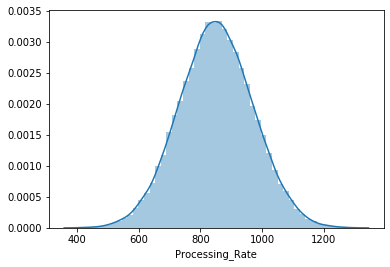

In [26]:
teste = PFI[(PFI['Site']==factory)]['Processing_Rate']
#Filtro o DataFrame

sns.distplot(teste)
print(f'Média de {teste.mean()}')
print(f'Desvio padrão de {teste.std()}')

In [27]:
equipment
#Temos 3 Equipamentos

,Number of RMI Drums,Number of PF Drums,Number of Pre-finish operation equipment,Number of PI Drums,Bag Machines,Box Machines
Manufacturing Facility,,,,,,
"Detroit, MI",40,15,2,8,1,1
"Columbus, OH",30,32,3,10,2,1
"Springfield, MO",50,24,1,15,1,1
"Green Bay, WI",20,17,2,17,1,1
"Omaha, NE",30,28,3,12,1,1


In [28]:
pi_drum[pi_drum['Site']==factory]

,Site,Drum Number,Capacity
33,"Green Bay, WI",FI Drum 1,"5,500"
34,"Green Bay, WI",FI Drum 2,"5,500"
35,"Green Bay, WI",FI Drum 3,"5,500"
36,"Green Bay, WI",FI Drum 4,"5,500"
37,"Green Bay, WI",FI Drum 5,"5,500"
38,"Green Bay, WI",FI Drum 6,"5,500"
39,"Green Bay, WI",FI Drum 7,"5,500"
40,"Green Bay, WI",FI Drum 8,"5,500"
41,"Green Bay, WI",FI Drum 9,"5,500"
42,"Green Bay, WI",FI Drum 10,"5,500"


## Packaging

In [29]:
#Temos 2 Bags e 1 Box
#Box line tem prefência sobre Bag (SimPY)
equipment

,Number of RMI Drums,Number of PF Drums,Number of Pre-finish operation equipment,Number of PI Drums,Bag Machines,Box Machines
Manufacturing Facility,,,,,,
"Detroit, MI",40,15,2,8,1,1
"Columbus, OH",30,32,3,10,2,1
"Springfield, MO",50,24,1,15,1,1
"Green Bay, WI",20,17,2,17,1,1
"Omaha, NE",30,28,3,12,1,1


Média de 1589.7858
Desvio padrão de 197.1124516160163


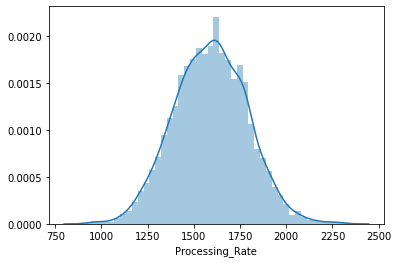

In [30]:
tipo = 'Bag' # 'Box'
teste2= packaging[(packaging['Site']==factory) & (packaging['Packaging_Type']==tipo)]['Processing_Rate']
#Filtro o DataFrame

sns.distplot(teste2)
print(f'Média de {teste2.mean()}')
print(f'Desvio padrão de {teste2.std()}')

In [31]:
pounds

,Pounds
Type,
Bag,0.25
Box,2.50


### Cria o DataFrame Auxiliar

In [32]:
# AUTOMATIZAR A DECLARAÇÃO DE PFI EQUIPMENTS PARA CADA FABRICA

machines = equipment[equipment.index==factory]['Number of Pre-finish operation equipment'][0]
pfi_names = []
for i in range(machines):
    pfi_names.append('PFI_'+str(i+1))

pfi_eq_aux = pd.DataFrame({'PFI': pfi_names, 'Sabor': "",'Ocupado':0 ,'Num':np.arange(machines), 'Ultimo_uso':0})
pfi_eq_aux.set_index('PFI',inplace=True)
pfi_eq_aux

,Sabor,Ocupado,Num,Ultimo_uso
PFI,,,,
PFI_1,,0,0,0
PFI_2,,0,1,0


In [33]:
pfi_drum_aux = pfi_drum[pfi_drum['Site']==factory].replace({'Drum Number': " ", 'Capacity In pounds':','},{'Drum Number': "_", 'Capacity In pounds':''},regex=True).drop(['Site'],axis=1).astype({'Capacity In pounds': 'int32'})
pfi_drum_aux['Level'] = 0
pfi_drum_aux['Cor'] = ''
pfi_drum_aux['Size'] = ''
pfi_drum_aux['Num'] = pfi_drum_aux['Drum Number'].apply(lambda x: int(x.split('PFI_Drum')[-1])-1)
pfi_drum_aux.set_index('Drum Number',inplace=True)
pfi_drum_aux.head()

,Capacity In pounds,Level,Cor,Size,Num
Drum Number,,,,,
PFI_Drum1,6500,0,,,0
PFI_Drum2,6500,0,,,1
PFI_Drum3,6500,0,,,2
PFI_Drum4,6500,0,,,3
PFI_Drum5,6500,0,,,4


In [34]:
fi_drum_aux = pi_drum[pi_drum['Site']==factory].replace({'Drum Number': ' ', 'Capacity':','}, {'Drum Number': '_', 'Capacity':''}, regex = True).astype({'Capacity': 'int32'})
fi_drum_aux['Level'] = 0
fi_drum_aux['Cor'] = ''
fi_drum_aux['Size'] = ''
fi_drum_aux['Flavor'] = ''
fi_drum_aux['Num'] = fi_drum_aux['Drum Number'].apply(lambda x: int(x.split('FI_Drum_')[-1])-1)
fi_drum_aux.set_index('Drum Number',drop=True, inplace = True)
fi_drum_aux.drop(['Site'],axis = 1, inplace = True)
fi_drum_aux

,Capacity,Level,Cor,Size,Flavor,Num
Drum Number,,,,,,
FI_Drum_1,5500,0,,,,0
FI_Drum_2,5500,0,,,,1
FI_Drum_3,5500,0,,,,2
FI_Drum_4,5500,0,,,,3
FI_Drum_5,5500,0,,,,4
FI_Drum_6,5500,0,,,,5
FI_Drum_7,5500,0,,,,6
FI_Drum_8,5500,0,,,,7
FI_Drum_9,5500,0,,,,8


### Começo o SimPY do Classifier

In [35]:
#obs: Gerenciamento da fila dos PFI Eq, Evitar SETUP
#obs: Classificador esperar só até 5...
#obs: Ordem muito grande trava tudo
#obs: lidar com decimais
#Esvaziar o RMI

box_espera = 0 #Variavel auxiliar para controle das filas
bag_espera = 0
classificador_ocupado = 0
ordens_extras = pd.DataFrame(columns = pmp_mae.columns) #tambor-morto
ordens_complementares = pd.DataFrame(columns = pmp_mae.columns) #quebra de ordens
ondens_sem_mp = pd.DataFrame(columns = pmp_mae.columns)
pmp_real = pd.DataFrame(columns = pmp_mae.columns) #real
classifier_balance = []
fim_sim = 0

def embalador(env, fi_drum_aux, FI_Drum, workorder, ordem, packaging, pounds, Bag, Box):
    #new: packaging, pounds, bag, box
    global box_espera, bag_espera, fim_sim
    
    #print(f'\nEmbalador executando a ordem {ordem} em {env.now}')
    
    color = workorder.iloc[ordem,2]
    size = workorder.iloc[ordem,3]
    flavor = workorder.iloc[ordem,4]
    pack = workorder.iloc[ordem,5]
    qtd_proc = workorder.iloc[ordem,6]
    
    retirar = qtd_proc
    
    #Começo as condicionais das prefêrencias para requisitar a linha
    if len(workorder[(workorder['Color']==color)&(workorder['Size']==size)&(workorder['Flavor']==flavor)&(workorder['Stage']==5)].index) > 0:
        
        pack_5 = workorder[(workorder['Color']==color)&(workorder['Size']==size)&(workorder['Flavor']==flavor)&(workorder['Stage']==5)]['Packaging Type'].iloc[0]

        if pack == 'Box' and pack_5 == 'Box':
            #Linha está executando Box e requisita Box
            req_box = Box.request()
            yield req_box
            #print(f'Ordem {ordem} requisitou Box em {env.now}')

        elif pack == 'Box' and pack_5 == 'Bag':
            #Linha está executando Bag e requisita Box
            #print(f'Ordem {ordem} de Box esperando Bag finalizar em {env.now}')

            while len(workorder[(workorder['Color']==color)&(workorder['Size']==size)&(workorder['Flavor']==flavor)&(workorder['Stage']==5)&(workorder['Packaging Type']=='Bag')].index) > 0:
                #Esperar finalizar a ordem de Bag
                box_espera = 1
                yield env.timeout(1)

            req_box = Box.request()
            yield req_box
            #print(f'Ordem {ordem} requisitou Box em {env.now}')
            box_espera = 0

        elif pack == 'Bag' and pack_5 == 'Bag':
            #Linha está executando Bag e requisita Bag
            if box_espera == 1:
                #print(f'Ordem {ordem} de Bag esperando Box finalizar em {env.now}')

                while box_espera == 1 or len(workorder[(workorder['Color']==color)&(workorder['Size']==size)&(workorder['Flavor']==flavor)&(workorder['Stage']==5)&(workorder['Packaging Type']=='Box')].index) > 0:
                    #Espera que todas as box esperando sejam processadas primeiro, para depois requisitar o bag
                    bag_espera = 1
                    yield env.timeout(1)

            req_bag = Bag.request()
            yield req_bag
            #print(f'Ordem {ordem} requisitou Bag em {env.now}')
            bag_espera = 0

        elif pack == 'Bag' and pack_5 == 'Box':
            #Linha está executando Box e requisita Bag
            #print(f'Ordem {ordem} de Bag esperando Box finalizar em {env.now}')
            while len(workorder[(workorder['Color']==color)&(workorder['Size']==size)&(workorder['Flavor']==flavor)&(workorder['Stage']==5)&(workorder['Packaging Type']=='Box')].index) > 0:
                #Esperar finalizar a ordem e a fila de Box 
                bag_espera = 1
                yield env.timeout(1)
            req_bag = Bag.request()
            yield req_bag
            #print(f'Ordem {ordem} requisitou Bag em {env.now}')
            bag_espera = 0
        else:
            print(f'Ordem {ordem} erro 1 em {env.now}')
            
    else: #Sem sku diferente
        if pack == 'Bag':
            req_bag = Bag.request()
            yield req_bag
            #print(f'Ordem {ordem} requisitou Bag em {env.now}')
            
        elif pack == 'Box':
            req_box = Box.request()
            yield req_box
            #print(f'Ordem {ordem} requisitou Box em {env.now}')
        else:
            print(f'Ordem {ordem} erro 2 em {env.now}')
            
    workorder.at[ordem,'Stage']=5
    #print(f'\nOrdem {ordem} mudou para o Stage 5 em {env.now}')
    
    #Calculo qual o fi_drum devo processar
    fi_drum_n = fi_drum_aux[(fi_drum_aux['Cor']==color) & (fi_drum_aux['Size']==size) & (fi_drum_aux['Flavor']==flavor)]['Num'].iloc[0]

    while qtd_proc > FI_Drum[fi_drum_n].level:
        #Limpo o RMI caso o retirar seja maior do que sua nivel restante
        qtd_proc = qtd_proc-FI_Drum[fi_drum_n].level

        FI_Drum[fi_drum_n].get(FI_Drum[fi_drum_n].level)
        #print(f'Esvaziar o FI_Drum {fi_drum_n+1} para a ordem {ordem} em {env.now}')

        fi_drum_aux.iat[fi_drum_n,1] = 0
        fi_drum_aux.iat[fi_drum_n,2] = ''
        fi_drum_aux.iat[fi_drum_n,3] = ''
        fi_drum_aux.iat[fi_drum_n,4] = ''

        fi_drum_n = fi_drum_aux[(fi_drum_aux['Cor']==color) & (fi_drum_aux['Size']==size) & (fi_drum_aux['Flavor']==flavor)]['Num'].iloc[0]
        #calcula qual o rmi_drum
    
    #Esvaziamos o FI Drum
    
    FI_Drum[fi_drum_n].get(qtd_proc) # max(qtd_proc,FI_Drum[fi_drum_n].level)
    
    #print(f'Ordem {ordem} Retirando {qtd_proc} do FI_Drum {fi_drum_n+1} da cor {color} e tamanho {size} e sabor {flavor}  em {env.now}\n')
        
    #Registrar que esvaziamos o PFI Drum para liberar o Classifier
    
    if FI_Drum[fi_drum_n].level ==0:
        fi_drum_aux.iat[fi_drum_n,1] = 0
        fi_drum_aux.iat[fi_drum_n,2] = ''
        fi_drum_aux.iat[fi_drum_n,3] = ''
        fi_drum_aux.iat[fi_drum_n,4] = ''
    else:
        fi_drum_aux.iat[fi_drum_n,1] = FI_Drum[fi_drum_n].level
    
    #Supondo Normalidade e sem diferença entre os tamanhos, calcula o tempo
    serie_hist = packaging[(packaging['Site']==factory) & (packaging['Packaging_Type']==pack)]['Processing_Rate'] #Série Histórica
    tempo_packging = (60*retirar/np.random.normal(serie_hist.mean(),serie_hist.std()))
     
    #Passa o tempo:    
    #print(f'\nTempo de processamento no Embalador {tempo_packging} da ordem {ordem} em {env.now}\n')
    yield env.timeout(tempo_packging)
    
    #Calcular quantas bags e box foram produzidas e finaliza o processo
    #obs: Ver como 'lidar' quando a ultima Bag ou Box for preenchida parcialmente
    
    if pack == 'Bag':
        bag_num = retirar/pounds.loc['Bag','Pounds']
        
        workorder.at[ordem,'Stage']=6
        workorder.at[ordem,'Fim']=env.now
        #print(f'\nOrdem {ordem} mudou para o Stage 6 em {env.now}')
        
        workorder.at[ordem,'Produzido']= str(bag_num)+' bags'
        print(f'Ordem {ordem} produziu {bag_num} bags em {env.now}')  
        
        #Finaliza o processo
        Bag.release(req_bag)
    
    elif pack == 'Box':
        box_num = retirar/pounds.loc['Box','Pounds']
        
        workorder.at[ordem,'Stage']=6
        workorder.at[ordem,'Fim']=env.now
        print(f'\nOrdem {ordem} mudou para o Stage 6 em {env.now}')
        
        workorder.at[ordem,'Produzido']=str(box_num)+' boxes'
        #print(f'Ordem {ordem} produziu {box_num} boxes em {env.now}') 
        
        #Finaliza o processo
        Box.release(req_box)
    fim_sim = env.now
    
#-----------------------------------------------------------------------------------------------------------

def saborizador(env, PFI_Drum, FI_Drum, PFI_Eq, pfi_drum_aux, PFI, workorder, ordem, fi_drum_aux, packaging, pounds, Bag, Box):
    global pmp_real
    
    #Adicionar ao pmp_real quem chegar na ordem que o povo chega na saborização
    pmp_real = pmp_real.append(workorder.iloc[ordem],sort=False)
    
    for i in range(len(pfi_eq_aux.index)):
    #Atualizo a tabela pfi_eq_aux
        if len(PFI_Eq[i].users)>0:
            pfi_eq_aux.iat[i,1] = 1
        else:
            pfi_eq_aux.iat[i,1] = 0
            
    #print(f'\nSaborizador executando a ordem {ordem} em {env.now} \n')
    color = workorder.iloc[ordem,2]
    size = workorder.iloc[ordem,3] 
    flavor = workorder.iloc[ordem,4] 
    qtd_proc = workorder.iloc[ordem,6]
    
    #Qual PFI Equipment eu vou requisitar: ---------------------
    
    if len(pfi_eq_aux[pfi_eq_aux['Ocupado']==0].index)>0: #Tenho um ou mais livres
        
        if len(pfi_eq_aux[(pfi_eq_aux['Ocupado']==0) & (pfi_eq_aux['Sabor']==flavor)].index) > 0:
            #Verificar se há um livre com meu sabor:
            num = pfi_eq_aux[(pfi_eq_aux['Ocupado']==0) & (pfi_eq_aux['Sabor']==flavor)].iloc[0,2]
            
        else:
            #Requisito o primeiro livre
            num = pfi_eq_aux[pfi_eq_aux['Ocupado']==0].iloc[0,2]   
            
    else: #Todos ocupados
        if len(pfi_eq_aux[(pfi_eq_aux['Sabor']==flavor)].index) > 0:
            #Verificar se há um ocupado com meu sabor:
            num = pfi_eq_aux[(pfi_eq_aux['Sabor']==flavor)].iloc[0,2]
            
        else:
            e_fila = []
            for e in PFI_Eq:
                e_fila.append(len(e.queue))
            num = pd.Series(e_fila).idxmin()
            #Pego o com menor fila
        
    #print(f'Ordem {ordem} Usara o PFI Equipment {num+1} em {env.now}')
    
    with PFI_Eq[num].request() as req:
        yield req
        
        sabor_old = pfi_eq_aux[pfi_eq_aux['Num']==num]['Sabor'].iloc[0]
        ultimo_uso = pfi_eq_aux[pfi_eq_aux['Num']==num]['Ultimo_uso'].iloc[0]
        
        setup = max(5-(env.now - ultimo_uso),0) #Tempo que falta para completar o SETUP
        
        if flavor != sabor_old and setup>0:
            
            #print(f'Setup de {setup} min na ordem {ordem} pois {flavor} diferente de {sabor_old} em {env.now}')
            yield env.timeout(setup)
            
        pfi_eq_aux.iat[num,0] = flavor #Recebe o sabor
        pfi_eq_aux.iat[num,3] = env.now
        
        #Calculo o PFI_Drum que devo retirar
        #OBS: RETIRAR DE MAIS DE 1 Drum quando necessário
        
        qtd = qtd_proc
        
        if qtd > pfi_drum_aux[(pfi_drum_aux['Cor']==color) & (pfi_drum_aux['Size']==size)]['Level'].sum():
            1==1
            #print(f'\nFalta Jujubas nos PFI Drums para a ordem {ordem} em {env.now}')
            #Em teoria esse if nunca deveria acontecer
            
        pfi_drum_n = pfi_drum_aux[(pfi_drum_aux['Cor']==color) & (pfi_drum_aux['Size']==size)]['Num'].iloc[0]
        #print(f'Ordem {ordem} em {env.now} com pfi_drum_n {pfi_drum_n+1} e PFI_Drum[pfi_drum_n].level {PFI_Drum[pfi_drum_n].level}\n')
        
        #print(f'\nqtd {qtd} e level {PFI_Drum[pfi_drum_n].level}')
        
        while qtd > PFI_Drum[pfi_drum_n].level:
            #Limpo o RMI caso o retirar seja maior do que sua nivel restante
            qtd = qtd-PFI_Drum[pfi_drum_n].level

            PFI_Drum[pfi_drum_n].get(PFI_Drum[pfi_drum_n].level)
            #print(f'Esvaziar o PFI_Drum {pfi_drum_n+1} para a ordem {ordem} em {env.now}')
            
            pfi_drum_aux.iat[pfi_drum_n,1] = 0
            pfi_drum_aux.iat[pfi_drum_n,2] = ''
            pfi_drum_aux.iat[pfi_drum_n,3] = ''

            pfi_drum_n = pfi_drum_aux[(pfi_drum_aux['Cor']==color) & (pfi_drum_aux['Size']==size)]['Num'].iloc[0]
            #calcula qual o pfi_drum

        #Esvaziamos o drum
        PFI_Drum[pfi_drum_n].get(qtd) #max(qtd,PFI_Drum[pfi_drum_n].level)
        #print(f'\nRetirado {qtd} do PFI_Drum {pfi_drum_n+1} da cor {color} e tamanho {size} para a ordem {ordem} em {env.now}')
        
        if PFI_Drum[pfi_drum_n].level ==0:
            pfi_drum_aux.iat[pfi_drum_n,1] = 0
            pfi_drum_aux.iat[pfi_drum_n,2] = ''
            pfi_drum_aux.iat[pfi_drum_n,3] = ''
        else:
            pfi_drum_aux.iat[pfi_drum_n,1] = PFI_Drum[pfi_drum_n].level
        
        #mudo o estado da workorder para 3 = PFI_Eq REQUISITADO
        workorder.at[ordem,'Stage']=3
        #print(f'\nOrdem {ordem} mudou para o Stage 3')
        
        serie_hist = PFI[(PFI['Site']==factory)]['Processing_Rate'] #Série Histórica
        tempo_PFI = 60*qtd_proc/np.random.normal(serie_hist.mean(),serie_hist.std())
        
        #print(f'\nTempo de processamento no Saborizador {tempo_PFI} na ordem {ordem} em {env.now}\n')
        #Passa o tempo:
        yield env.timeout(tempo_PFI)
        
        qtd_lista = []
        
        #Verifico a capacidade rstante de FI Drums já preenchidos com a mesma cor, tamanho e sabor
        fi_drum_2 = fi_drum_aux[(fi_drum_aux['Cor']==color) & (fi_drum_aux['Size'] == size) & (fi_drum_aux['Flavor'] == flavor)]
        fi_drum_2.loc[:,'restante'] = fi_drum_2.loc[:,'Capacity'].add(-fi_drum_2.loc[:,'Level'])
        restante = fi_drum_2['restante'].sum()
        
        if restante >0:
            if restante >= qtd_proc:
                #Não precisa de novos FI Drums
                qtd_lista.append(qtd_proc)
                qtd_proc=0
            else:
                qtd_proc = qtd_proc - restante
                qtd_lista.append(restante)
        else:
            qtd_lista.append(None)
        
        while qtd_proc > FI_Drum[0].capacity:
            qtd_proc = qtd_proc - FI_Drum[0].capacity
            qtd_lista.append(FI_Drum[0].capacity)
            
        if qtd_proc >0:
            qtd_lista.append(qtd_proc)
        #Calculo quantos FI Drums eu vou precisar
        
        if len(fi_drum_aux[fi_drum_aux.Level==0].index) < (len(qtd_lista)-1):
            #print(f'Ordem {ordem} presa no Loop do Saborizador por Falta de FI Drum em {env.now}')   
            while len(fi_drum_aux[fi_drum_aux.Level==0].index) < (len(qtd_lista)-1):
                #Esperar até que haja 1 FI Drum Vazio
                
                qtd_lista = []
                #Verifico a capacidade rstante de FI Drums já preenchidos com a mesma cor, tamanho e sabor
                fi_drum_2 = fi_drum_aux[(fi_drum_aux['Cor']==color) & (fi_drum_aux['Size'] == size) & (fi_drum_aux['Flavor'] == flavor)]
                fi_drum_2.loc[:,'restante'] = fi_drum_2.loc[:,'Capacity'].add(-fi_drum_2.loc[:,'Level'])
                restante = fi_drum_2['restante'].sum()

                if restante >0:
                    if restante >= qtd_proc:
                        #Não precisa de novos FI Drums
                        qtd_lista.append(qtd_proc)
                        qtd_proc=0
                    else:
                        qtd_proc = qtd_proc - restante
                        qtd_lista.append(restante)
                else:
                    qtd_lista.append(None)

                while qtd_proc > FI_Drum[0].capacity:
                    qtd_proc = qtd_proc - FI_Drum[0].capacity
                    qtd_lista.append(FI_Drum[0].capacity)

                if qtd_proc >0:
                    qtd_lista.append(qtd_proc)
                
                yield env.timeout(1)
        
        if qtd_lista[0] != None:
            #Preenche primeiro o FI Drum com capacidade restante
            FI_n = fi_drum_aux[(fi_drum_aux['Cor']==color) & (fi_drum_aux['Level']< FI_Drum[0].capacity) & (fi_drum_aux['Size'] == size) & (fi_drum_aux['Flavor'] == flavor)]['Num'].iloc[0]
            FI_idx = fi_drum_aux[(fi_drum_aux['Cor']==color) & (fi_drum_aux['Level']< FI_Drum[0].capacity) & (fi_drum_aux['Size'] == size) & (fi_drum_aux['Flavor'] == flavor)]['Num'].index[0]
            
            while qtd_lista[0] > (FI_Drum[FI_n].capacity - FI_Drum[FI_n].level):
                #Limpo o RMI caso o retirar seja maior do que sua nivel restante
                qtd_lista[0] = qtd_lista[0]-(FI_Drum[FI_n].capacity - FI_Drum[FI_n].level)
                
                FI_Drum[FI_n].put((FI_Drum[FI_n].capacity - FI_Drum[FI_n].level))
                #print(f'Preencher FI_Drum {FI_n+1} de level {FI_Drum[FI_n].level} com {qtd_lista[0]} para ordem {ordem} em {env.now}')

                fi_drum_aux.at[FI_idx,'Level'] = FI_Drum[FI_n].level 
                
                FI_n = fi_drum_aux[(fi_drum_aux['Cor']==color) & (fi_drum_aux['Level']< FI_Drum[0].capacity) & (fi_drum_aux['Size'] == size) & (fi_drum_aux['Flavor'] == flavor)]['Num'].iloc[0]
                FI_idx = fi_drum_aux[(fi_drum_aux['Cor']==color) & (fi_drum_aux['Level']< FI_Drum[0].capacity) & (fi_drum_aux['Size'] == size) & (fi_drum_aux['Flavor'] == flavor)]['Num'].index[0]

            FI_Drum[FI_n].put(qtd_lista[0])
            #print(f'Preencher FI_Drum {FI_n+1} de level {FI_Drum[FI_n].level} com {qtd_lista[0]} para ordem {ordem} em {env.now}')
            fi_drum_aux.at[FI_idx,'Level'] = FI_Drum[FI_n].level 
            
        retirar = pd.Series(qtd_lista[1:]).sum()
        
        if retirar >0:
            #Calcula o FI Drum a ser abastecido        
            FI_n = fi_drum_aux[fi_drum_aux['Level']==0]['Num'].iloc[0]
            FI_idx = fi_drum_aux[fi_drum_aux['Level']==0]['Num'].index[0]

            while retirar > FI_Drum[FI_n].capacity:
                #Realiza a repartição do retirar
                retirar = retirar-FI_Drum[FI_n].capacity

                FI_Drum[FI_n].put(FI_Drum[FI_n].capacity)
                #print(f'Preencher FI_Drum {FI_n+1} com {FI_Drum[FI_n].capacity} para ordem {ordem} em {env.now}')

                fi_drum_aux.at[FI_idx,'Cor'] = color
                fi_drum_aux.at[FI_idx,'Size'] = size
                fi_drum_aux.at[FI_idx,'Flavor'] = flavor
                fi_drum_aux.at[FI_idx,'Level'] = FI_Drum[FI_n].capacity

                FI_n = fi_drum_aux[fi_drum_aux['Level']==0]['Num'].iloc[0]
                FI_idx = fi_drum_aux[fi_drum_aux['Level']==0]['Num'].index[0]

            #print(f'Preencher FI_Drum {FI_n+1} com {retirar} para ordem {ordem}  em {env.now}\n')
            #Encho o FI_Drum
            FI_Drum[FI_n].put(retirar)

            fi_drum_aux.at[FI_idx,'Cor'] = color
            fi_drum_aux.at[FI_idx,'Size'] = size
            fi_drum_aux.at[FI_idx,'Flavor'] = flavor
            fi_drum_aux.at[FI_idx,'Level'] = retirar
        
        #Passa para o Stage 4 quem passou pelo PFI
        workorder.at[ordem,'Stage']=4
        #print(f'\nOrdem {ordem} mudou para o Stage 4 em {env.now}')

        #CHAMAR O PACKAGING
        env.process(embalador(env, fi_drum_aux, FI_Drum, workorder, ordem, packaging, pounds, Bag, Box))
        
#-----------------------------------------------------------------------------------------------------------
    
def classificador (env, classifier, classifier_rates, split, RMI_DRUM, PFI_Drum, qtd, color, pfi_drum_aux, workorder, ordem, FI_Drum, PFI_Eq, PFI, fi_drum_aux, packaging, pounds, Bag, Box, pmp_lixo):
    global ordens_extras, ordens_complementares, classificador_ocupado, classifier_balance
    
    #print(f'\nClassificador executando a ordem {ordem} em {env.now}')
    classifier_balance.append([factory, color, qtd])
    if qtd > 0:
        #Só ativa o Classifier se necessário
        
        qtd_time = qtd
        
        req_classifier = classifier.request()
        #Requisita o classificador somente se necessário
        yield req_classifier
        classificador_ocupado = 1

        rmi_drum_idx = RMI[(RMI['Location Name']==factory) & (RMI['Color'] == color) & (RMI['Qty in pounds'] > 0)].index[0]
        rmi_drum_n = RMI[(RMI['Location Name']==factory) & (RMI['Color'] == color) & (RMI['Qty in pounds'] > 0)].iloc[0,5]
        #calcula qual o rmi_drum

        while qtd > RMI_DRUM[rmi_drum_n].level:
            #Limpo o RMI caso o retirar seja maior do que sua nivel restante
            qtd = qtd-RMI_DRUM[rmi_drum_n].level

            RMI_DRUM[rmi_drum_n].get(RMI_DRUM[rmi_drum_n].level)
            #print(f'Esvaziar o RMI_Drum {rmi_drum_n+1} para a ordem {ordem} em {env.now}')

            RMI.at[rmi_drum_idx,'Color'] = ''
            RMI.at[rmi_drum_idx,'Qty in pounds'] = 0

            rmi_drum_idx = RMI[(RMI['Location Name']==factory) & (RMI['Color'] == color) & (RMI['Qty in pounds'] > 0)].index[0]
            rmi_drum_n = RMI[(RMI['Location Name']==factory) & (RMI['Color'] == color) & (RMI['Qty in pounds'] > 0)].iloc[0,5]
            #calcula qual o rmi_drum

        RMI_DRUM[rmi_drum_n].get(qtd)
        #print(f'\nRetirado {qtd} do RMI_Drum {rmi_drum_n+1} para a ordem {ordem} em {env.now}')
        #Retira do RMI especificado a qtd necessária

        if RMI_DRUM[rmi_drum_n].level ==0:
            RMI.at[rmi_drum_idx,'Qty in pounds'] = 0
            RMI.at[rmi_drum_idx,'Color'] = ''
        else:
            RMI.at[rmi_drum_idx,'Qty in pounds'] = RMI_DRUM[rmi_drum_n].level

        tempo_classifier = (qtd_time/classifier_rates[classifier_rates['Site']==factory].iloc[0,2])*60
        #print(f'\nTempo de processamento no Classificador {tempo_classifier} na ordem {ordem} em {env.now}\n')
        yield env.timeout(tempo_classifier)
        #Passa o tempo em minutos
        classificador_ocupado = 0
        
        divisao = split[(split['Color ']==color)].sort_values(by=['Size']).set_index('Size')['Percentage ']*qtd_time/100
        divisao = divisao.apply(np.floor)
        #Calcula o percentual divido de cada um dos cinco tamanhos em pounds e enche os 5 PFI Drums
        
        #Verifico a capacidade rstante de PFI Drums já preenchidos com a mesma cor
        pfi_drum_2 = pfi_drum_aux[(pfi_drum_aux['Cor']==color)]
        pfi_drum_2.loc[:,'restante'] = (pfi_drum_2.loc[:,'Capacity In pounds']*0.95).add(-pfi_drum_2.loc[:,'Level'])
        pfi_drum_2 = pfi_drum_2.groupby('Size').sum()['restante']

        divisao2 = divisao.add(-pfi_drum_2, fill_value=0)
        divisao2 = divisao2[divisao2>0]
        #Calculo quanto eu precisaria encher de cada tamanho após usar os já preenchidos (ou seja, tambores novos)
        #print(f'ordem{ordem} e divisao2 \n{divisao2}')

        divisao3 = divisao.add(-divisao2, fill_value=0)
        divisao3 = divisao3[divisao3>0]            
        #Calculo quanto eu preciso encher nos PFI Drums já preenchidos
        
        #print(f'\n{divisao3}')
                
        rest= pd.Series([])
        #print(divisao2)
        
        for i in divisao2.index:
            #Caso precise de mais de 5 tambores
            while divisao2[i] > 0.95*PFI_Drum[0].capacity:
                divisao2[i] = divisao2[i] - 0.95*PFI_Drum[0].capacity
                rest = rest.append(pd.Series([0.95*PFI_Drum[0].capacity],index=[i]))
        divisao2 = divisao2.append(rest)
        
        #Espera até que haja 5 ou mais PFI Drums vazios
        if len(pfi_drum_aux[pfi_drum_aux.Level==0].index) < len(divisao2):
            
            #print(f'\nOrdem {ordem} presa no Loop do Classificador por Falta de PFI Drum em {env.now}')
            #Saber se é uma morte momentanea ou definitiva
            
            usara = workorder[(workorder['Stage']==2)].copy()
            #usara são as ordens na fila da saborização

            pfi_futuro = pfi_drum_aux.copy()
            #pfi_futuro será o pfi_drum_aux após a execução das ordens na fila da saborização

            for i in usara.index:
                uso = usara.loc[i,'Qty']

                pfi_drum_n = pfi_futuro[(pfi_futuro['Cor']==usara.loc[i,'Color']) & (pfi_futuro['Size']==usara.loc[i,'Size'])]['Num'].iloc[0]

                while uso > pfi_futuro.iloc[pfi_drum_n].Level:

                    uso = uso-pfi_futuro.iloc[pfi_drum_n].Level
                    #print(f'\n[PMP] o PFI_Drum {pfi_drum_n+1} será esvaziado na ordem {i}')

                    pfi_futuro.iat[pfi_drum_n,1] = 0
                    pfi_futuro.iat[pfi_drum_n,2] = ''
                    pfi_futuro.iat[pfi_drum_n,3] = ''

                    pfi_drum_n = pfi_futuro[(pfi_futuro['Cor']==usara.loc[i,'Color']) & (pfi_futuro['Size']==usara.loc[i,'Size'])]['Num'].iloc[0]

                if (pfi_futuro.iloc[pfi_drum_n].Level - uso)==0:
                    #print(f'\n[PMP] o PFI_Drum {pfi_drum_n+1} será esvaziado na ordem {i}')
                    pfi_futuro.iat[pfi_drum_n,1] = 0
                    pfi_futuro.iat[pfi_drum_n,2] = ''
                    pfi_futuro.iat[pfi_drum_n,3] = ''
                else:
                    pfi_futuro.iat[pfi_drum_n,1] = pfi_futuro.iloc[pfi_drum_n].Level - uso

            #print(f'ordem {ordem} com pfi_futuro \n{pfi_futuro}')
            #eu preciso calcular divisao2 futura pq isso vai ser uma merda, divisao é eterno

            pfi_futuro['Stage_Faltante'] = pfi_futuro.apply(lambda x: workorder[(workorder['Color']==x['Cor']) & (workorder['Size']==x['Size'])]['Stage'].min(), axis=1)
            #Tambores com stage faltante >=2 são mortos, pois já tiveram seus gets contabilizados no pfi_futuro. O resto é lixo (vivo)

            lixo = len(pfi_futuro[(pfi_futuro['Level'] > 0) & (pfi_futuro['Stage_Faltante'] < 1) & ~((pfi_futuro['Size'] == workorder.iloc[ordem,3]) & (pfi_futuro['Cor'] == color))].index)
            #print(f'ordem {ordem} com divisao2_futuro \n{divisao2_futuro}')
            
            pfi_drum_2_futuro = pfi_futuro[(pfi_futuro['Cor']==color)].copy()
            pfi_drum_2_futuro['restante'] = pfi_drum_2_futuro.apply(lambda x: x['Capacity In pounds']*0.95 - x['Level'],axis=1,result_type='reduce')
            pfi_drum_2_futuro = pfi_drum_2_futuro.groupby('Size').sum()['restante']

            divisao2_futuro = divisao.add(-pfi_drum_2_futuro, fill_value=0)
            divisao2_futuro = divisao2_futuro[divisao2_futuro>0]

            divisao3_futuro = divisao.add(-divisao2_futuro, fill_value=0)
            divisao3_futuro = divisao3_futuro[divisao3_futuro>0]

            rest= pd.Series([])
            for i in divisao2_futuro.index:
                #Caso precise de mais de 5 tambores
                while divisao2_futuro[i] > 0.95*PFI_Drum[0].capacity:
                    divisao2_futuro[i] = divisao2_futuro[i] - 0.95*PFI_Drum[0].capacity
                    rest = rest.append(pd.Series([0.95*PFI_Drum[0].capacity],index=[i]))
            divisao2_futuro = divisao2_futuro.append(rest)
                
            if len(divisao2_futuro) <= len(pfi_futuro[pfi_futuro.Level==0].index):
                1==1
                #print(f'\nMorte momentanea na ordem {ordem} em {env.now}')
            
            else:
                preciso_liberar = len(divisao2_futuro) - len(pfi_futuro[pfi_futuro.Level==0].index) #Target
                
                #print(f'\nMorte definitiva na ordem {ordem} em {env.now} que precisa liberar {preciso_liberar} pfi drums')
                x = 0
                
                while preciso_liberar > 0:
                    
                    if lixo > 0:
                        #Tento passar a primeira ordem do pmp_lixo, mas tenho que ver se tenho estoque
                        # a ordem é pmp_lixo.iloc[x]
                        
                        estoque = pfi_futuro[(pfi_futuro['Cor'] == pmp_lixo.iloc[x]['Color']) & (pfi_futuro['Size'] == pmp_lixo.iloc[x]['Size'])]['Level'].sum()
                        if (pmp_lixo.iloc[x]['Qty'] <= estoque) and not((pmp_lixo.iloc[x]['Color'] == color) and (pmp_lixo.iloc[x]['Size'] == workorder.iloc[ordem,3])):
                            #print(f'\nTenho estoque para a ordem pmp_lixo {x}')
                            
                            #Tenho que enviar a ordem utilizando a posição dela na pmp_mae, apagar da pmp_lixo e registrar ela como stage 2
                            
                            ordem_lixo = workorder[workorder['Internal Work Order Id']==pmp_lixo.iloc[x]['Internal Work Order Id']].index[0]
                            workorder.at[ordem_lixo,'Stage']=2
                            workorder.at[ordem_lixo,'Inicio']=env.now
                            #Vejo qual o indice da ordem no pmp_mae, registro que ela está no stage 2 e envio para a saborização
                            
                            env.process(saborizador(env, PFI_Drum, FI_Drum, PFI_Eq, pfi_drum_aux, PFI, workorder, ordem_lixo, fi_drum_aux, packaging, pounds, Bag, Box))
                            #print(f'\nEnviada a ordem_lixo {ordem_lixo} para liberar a ordem {ordem} em {env.now}')
                            #envio para a saborização
                            
                            pmp_lixo.drop(x, inplace = True)
                            pmp_lixo.reset_index(drop=True,inplace=True)
                            #removo do pmp_lixo, reseto_index e não altero x
                            
                            #Atualizo pfi_futuro

                            pfi_drum_n = pfi_futuro[(pfi_futuro['Cor'] == workorder.iloc[ordem_lixo]['Color']) & (pfi_futuro['Size'] == workorder.iloc[ordem_lixo]['Size'])]['Num'].iloc[0]
                            uso = workorder.iloc[ordem_lixo]['Qty']

                            while uso > pfi_futuro.iloc[pfi_drum_n].Level:

                                uso = uso-pfi_futuro.iloc[pfi_drum_n].Level
                                #print(f'\n[PMP] o PFI_Drum {pfi_drum_n+1} será esvaziado na ordem pmp_lixo {ordem_lixo}')

                                pfi_futuro.iat[pfi_drum_n,1] = 0
                                pfi_futuro.iat[pfi_drum_n,2] = ''
                                pfi_futuro.iat[pfi_drum_n,3] = ''

                                pfi_drum_n = pfi_futuro[(pfi_futuro['Cor'] == workorder.iloc[ordem_lixo]['Color']) & (pfi_futuro['Size'] == workorder.iloc[ordem_lixo]['Size'])]['Num'].iloc[0]

                            if (pfi_futuro.iloc[pfi_drum_n].Level - uso)==0:
                                #print(f'\n[PMP] o PFI_Drum {pfi_drum_n+1} será esvaziado na ordem pmp_lixo {ordem_lixo}')
                                pfi_futuro.iat[pfi_drum_n,1] = 0
                                pfi_futuro.iat[pfi_drum_n,2] = ''
                                pfi_futuro.iat[pfi_drum_n,3] = ''
                            else:
                                pfi_futuro.iat[pfi_drum_n,1] = pfi_futuro.iloc[pfi_drum_n].Level - uso
                            
                            pfi_futuro['Stage_Faltante'] = pfi_futuro.apply(lambda x: workorder[(workorder['Color']==x['Cor']) & (workorder['Size']==x['Size'])]['Stage'].min(), axis=1)
                                
                            #print(f'pfi_futuro após a ordem pmp_lixo {ordem_lixo}\n {pfi_futuro}')
                            x = 0

                        elif estoque >0 and not((pmp_lixo.iloc[x]['Color'] == color) and (pmp_lixo.iloc[x]['Size'] == workorder.iloc[ordem,3])):
                            #Haverá uma ordem em pmp_morto que não precisa ser quebrada?
                            if len(pmp_lixo[(pmp_lixo['Color']==pmp_lixo.iloc[x]['Color']) & (pmp_lixo['Size']==pmp_lixo.iloc[x]['Size']) & (pmp_lixo['Qty'] <= estoque)].index)>0:
                                #Se sim, espero por essa ordem para não quebrar a ordem de um cliente
                                #print(f'\nNão preciso quebrar a ordem_lixo {x} para ordem {ordem} em {env.now}')
                                x+=1
                                
                            elif len(pfi_futuro[(pfi_futuro['Level'] > 0) & (pfi_futuro['Stage_Faltante'] >= 2)].index)>0:
                                #Prefiro cor morta do que quebrar a ordem
                                #print(f'\nEsvaziar cores mortas para ordem {ordem} em {env.now}')

                                tambores_mortos = pfi_futuro[(pfi_futuro['Level'] > 0) & (pfi_futuro['Stage_Faltante']>=2)].iloc[:preciso_liberar]

                                workorder_fantasma = pd.DataFrame(data={'Color':tambores_mortos['Cor'], 'Size':tambores_mortos['Size'], 'Qty':tambores_mortos['Level'], 'Plant Id':factory, 'Flavor': workorder.iloc[ordem,4],'Packaging Type':'Bag', 'Stage':2, 'Inicio': env.now},columns = workorder.columns)
                                ordem_fantasma = np.arange(len(tambores_mortos.index)) + len(workorder.index)
                                workorder_fantasma.index = ordem_fantasma
                                #print(f'\n workorder_fantasma para ordem {ordem} em {env.now} \n{workorder_fantasma}')

                                ordens_extras = ordens_extras.append(workorder_fantasma)

                                for i in ordem_fantasma:
                                    #Envio as ordens fantasmas
                                    workorder.loc[i] = list(workorder_fantasma.loc[i])

                                    env.process(saborizador(env, PFI_Drum, FI_Drum, PFI_Eq, pfi_drum_aux, PFI, workorder, i, fi_drum_aux, packaging, pounds, Bag, Box))
                                    #print(f'\nEnviada a workorder_fantasma {i} para ordem {ordem} em {env.now}')
                                    #Atualizar preciso_liberar
                                    pfi_drum_n = pfi_futuro[(pfi_futuro['Level'] > 0) & (pfi_futuro['Cor'] == workorder.loc[i]['Color']) & (pfi_futuro['Size'] == workorder.loc[i]['Size'])]['Num'].iloc[0]
                                    uso = workorder.loc[i]['Qty']

                                    while uso > pfi_futuro.iloc[pfi_drum_n].Level:

                                        uso = uso-pfi_futuro.iloc[pfi_drum_n].Level
                                        #print(f'\n[PMP] o PFI_Drum {pfi_drum_n+1} será esvaziado na ordem fantasma {i}')

                                        pfi_futuro.iat[pfi_drum_n,1] = 0
                                        pfi_futuro.iat[pfi_drum_n,2] = ''
                                        pfi_futuro.iat[pfi_drum_n,3] = ''

                                        pfi_drum_n = pfi_futuro[(pfi_futuro['Level'] > 0) & (pfi_futuro['Cor'] == workorder.loc[i]['Color']) & (pfi_futuro['Size'] == workorder.loc[i]['Size'])]['Num'].iloc[0]

                                    if (pfi_futuro.iloc[pfi_drum_n].Level - uso)==0:
                                        #print(f'\n[PMP] o PFI_Drum {pfi_drum_n+1} será esvaziado na ordem pmp_lixo {i}')
                                        pfi_futuro.iat[pfi_drum_n,1] = 0
                                        pfi_futuro.iat[pfi_drum_n,2] = ''
                                        pfi_futuro.iat[pfi_drum_n,3] = ''
                                    else:
                                        pfi_futuro.iat[pfi_drum_n,1] = pfi_futuro.iloc[pfi_drum_n].Level - uso

                                    pfi_futuro['Stage_Faltante'] = pfi_futuro.apply(lambda x: workorder[(workorder['Color']==x['Cor']) & (workorder['Size']==x['Size'])]['Stage'].min(), axis=1)
                                    x = 0    
                                    #print(f'pfi_futuro após a ordem fantasma {i}\n {pfi_futuro}')
                                
                            else:
                                #print(f'\nQuebrar a ordem pmp_lixo {x} para liberar a ordem {ordem} em {env.now}')
                                
                                sobra = pmp_lixo.iloc[x]['Qty'] - estoque
                                pmp_lixo_id = pmp_lixo.iloc[x]['Internal Work Order Id']
                                
                                ordem_lixo = workorder[workorder['Internal Work Order Id']==pmp_lixo_id].index[0]
                                workorder.at[ordem_lixo,'Stage']=2
                                workorder.at[ordem_lixo,'Inicio']=env.now
                                workorder.at[ordem_lixo,'Qty']= estoque
                                #Busco o indice, registro stage 2, altero 'Qty' para 'estoque' e envio para a saborização
                            
                                env.process(saborizador(env, PFI_Drum, FI_Drum, PFI_Eq, pfi_drum_aux, PFI, workorder, ordem_lixo, fi_drum_aux, packaging, pounds, Bag, Box))
                                #print(f'\nEnviada a ordem_lixo {ordem_lixo} para liberar a ordem {ordem} em {env.now}')
                                #envio para a saborização
                                
                                #Atualizo pfi_futuro

                                pfi_drum_n = pfi_futuro[(pfi_futuro['Cor'] == workorder.iloc[ordem_lixo]['Color']) & (pfi_futuro['Size'] == workorder.iloc[ordem_lixo]['Size'])]['Num'].iloc[0]
                                uso = workorder.iloc[ordem_lixo]['Qty']

                                while uso > pfi_futuro.iloc[pfi_drum_n].Level:

                                    uso = uso-pfi_futuro.iloc[pfi_drum_n].Level
                                    #print(f'\n[PMP] o PFI_Drum {pfi_drum_n+1} será esvaziado na ordem pmp_lixo {ordem_lixo}')

                                    pfi_futuro.iat[pfi_drum_n,1] = 0
                                    pfi_futuro.iat[pfi_drum_n,2] = ''
                                    pfi_futuro.iat[pfi_drum_n,3] = ''

                                    pfi_drum_n = pfi_futuro[(pfi_futuro['Cor'] == workorder.iloc[ordem_lixo]['Color']) & (pfi_futuro['Size'] == workorder.iloc[ordem_lixo]['Size'])]['Num'].iloc[0]

                                if (pfi_futuro.iloc[pfi_drum_n].Level - uso)==0:
                                    #print(f'\n[PMP] o PFI_Drum {pfi_drum_n+1} será esvaziado na ordem pmp_lixo {ordem_lixo}')
                                    pfi_futuro.iat[pfi_drum_n,1] = 0
                                    pfi_futuro.iat[pfi_drum_n,2] = ''
                                    pfi_futuro.iat[pfi_drum_n,3] = ''
                                else:
                                    pfi_futuro.iat[pfi_drum_n,1] = pfi_futuro.iloc[pfi_drum_n].Level - uso
                                    
                                pfi_futuro['Stage_Faltante'] = pfi_futuro.apply(lambda x: workorder[(workorder['Color']==x['Cor']) & (workorder['Size']==x['Size'])]['Stage'].min(), axis=1)

                                #print(f'pfi_futuro após a ordem pmp_lixo {x}\n {pfi_futuro}')
                                
                                #Crio uma ordem para a classificação com a sobra:
                                workorder_complementar = pmp_lixo.iloc[x].copy()
                                workorder_complementar.at['Qty'] = sobra
                                ordem_complementar = len(workorder.index)
                                
                                qtd_complementar = math.ceil(sobra/(split[(split['Color ']== workorder_complementar.loc['Color']) & (split['Size']== workorder_complementar.loc['Size'])].iloc[0,2]/100))
                                #calcula a quantidade a ser retirada do RMI (SOMENTE O NECESSÁRIO)

                                disponivel = RMI[(RMI['Location Name']==factory) & (RMI['Color'] == workorder_complementar.loc['Color'])]['Qty in pounds'].sum()
                                
                                #Verificar se a fábrica tem a cor e a quantidade necessária:

                                if disponivel >= qtd_complementar:
                                    
                                    workorder_complementar.at['Stage'] = 1
                                    workorder_complementar.at['Inicio']=env.now
                                    workorder.loc[ordem_complementar] = workorder_complementar
                                    #adiciono ela no pmp_mae
                                    ordens_complementares = ordens_complementares.append(workorder_complementar,sort=False)
                                
                                    env.process(classificador(env, classifier, classifier_rates, split, RMI_DRUM, PFI_Drum, qtd_complementar, workorder_complementar.loc['Color'], pfi_drum_aux, workorder, ordem_complementar, FI_Drum, PFI_Eq, PFI, fi_drum_aux,packaging, pounds, Bag, Box, pmp_lixo))
                                    #mando pro classificador
                                    #print(f'\n workorder_complementar \n{ordem_complementar}\nPara a ordem pmp_lixo {ordem_lixo} em {env.now} \n{workorder_complementar}')
                                else:
                                    #print(f'\n workorder_complementar \n{ordem_complementar} sem RMI suficiente)')
                                    workorder_complementar.at['Stage'] = 99
                                    workorder.loc[ordem_complementar] = workorder_complementar
                                    #adiciono ela no pmp_mae
                                    ordens_complementares = ordens_complementares.append(workorder_complementar,sort=False)
                                    
                                pmp_lixo.drop(x, inplace = True)
                                pmp_lixo.reset_index(drop=True,inplace=True)
                                #removo do pmp_lixo, reseto_index e não altero x
                                x = 0

                        else:
                            #Estoque para a ordem x é 0 então pulo até que haja uma ordem x com estoque
                            x+=1
                    else:
                        #Preciso processar cor morta
                        #print(f'\nEsvaziar cores mortas para ordem {ordem} em {env.now}')
                        
                        tambores_mortos = pfi_futuro[(pfi_futuro['Level'] > 0) & (pfi_futuro['Stage_Faltante']>=2)].iloc[:preciso_liberar]

                        workorder_fantasma = pd.DataFrame(data={'Color':tambores_mortos['Cor'], 'Size':tambores_mortos['Size'], 'Qty':tambores_mortos['Level'], 'Plant Id':factory, 'Flavor': workorder.iloc[ordem,4],'Packaging Type':'Bag', 'Stage':2, 'Inicio': env.now},columns = workorder.columns)
                        ordem_fantasma = np.arange(len(tambores_mortos.index)) + len(workorder.index)
                        workorder_fantasma.index = ordem_fantasma
                        #print(f'\n workorder_fantasma para ordem {ordem} em {env.now} \n{workorder_fantasma}')

                        ordens_extras = ordens_extras.append(workorder_fantasma)

                        for i in ordem_fantasma:
                            #Envio as ordens fantasmas
                            workorder.loc[i] = list(workorder_fantasma.loc[i])
                            
                            env.process(saborizador(env, PFI_Drum, FI_Drum, PFI_Eq, pfi_drum_aux, PFI, workorder, i, fi_drum_aux, packaging, pounds, Bag, Box))
                            #print(f'\nEnviada a workorder_fantasma {i} para ordem {ordem} em {env.now}')
                            #Atualizar preciso_liberar
                            pfi_drum_n = pfi_futuro[(pfi_futuro['Level'] > 0) & (pfi_futuro['Cor'] == workorder.loc[i]['Color']) & (pfi_futuro['Size'] == workorder.loc[i]['Size'])]['Num'].iloc[0]
                            uso = workorder.loc[i]['Qty']

                            while uso > pfi_futuro.iloc[pfi_drum_n].Level:

                                uso = uso-pfi_futuro.iloc[pfi_drum_n].Level
                                #print(f'\n[PMP] o PFI_Drum {pfi_drum_n+1} será esvaziado na ordem fantasma {i}')

                                pfi_futuro.iat[pfi_drum_n,1] = 0
                                pfi_futuro.iat[pfi_drum_n,2] = ''
                                pfi_futuro.iat[pfi_drum_n,3] = ''

                                pfi_drum_n = pfi_futuro[(pfi_futuro['Level'] > 0) & (pfi_futuro['Cor'] == workorder.loc[i]['Color']) & (pfi_futuro['Size'] == workorder.loc[i]['Size'])]['Num'].iloc[0]

                            if (pfi_futuro.iloc[pfi_drum_n].Level - uso)==0:
                                #print(f'\n[PMP] o PFI_Drum {pfi_drum_n+1} será esvaziado na ordem pmp_lixo {i}')
                                pfi_futuro.iat[pfi_drum_n,1] = 0
                                pfi_futuro.iat[pfi_drum_n,2] = ''
                                pfi_futuro.iat[pfi_drum_n,3] = ''
                            else:
                                pfi_futuro.iat[pfi_drum_n,1] = pfi_futuro.iloc[pfi_drum_n].Level - uso
                                
                            pfi_futuro['Stage_Faltante'] = pfi_futuro.apply(lambda x: workorder[(workorder['Color']==x['Cor']) & (workorder['Size']==x['Size'])]['Stage'].min(), axis=1)
                            x = 0    
                            #print(f'pfi_futuro após a ordem fantasma {i}\n {pfi_futuro}')
                    
                    #Eu atualizei meu pfi_futuro após as ordens que eu enviei e agora preciso ver como divisao2_futura reage
                    pfi_drum_2_futuro = pfi_futuro[(pfi_futuro['Cor']==color)]
                    pfi_drum_2_futuro['restante'] = pfi_drum_2_futuro.apply(lambda x: x['Capacity In pounds']*0.95 - x['Level'],axis=1,result_type='reduce')
                    pfi_drum_2_futuro = pfi_drum_2_futuro.groupby('Size').sum()['restante']

                    divisao2_futuro = divisao.add(-pfi_drum_2_futuro, fill_value=0)
                    divisao2_futuro = divisao2_futuro[divisao2_futuro>0]

                    divisao3_futuro = divisao.add(-divisao2_futuro, fill_value=0)
                    divisao3_futuro = divisao3_futuro[divisao3_futuro>0]
                    
                    rest= pd.Series([])
                    #print(divisao2)

                    for i in divisao2_futuro.index:
                        #Caso precise de mais de 5 tambores
                        while divisao2_futuro[i] > 0.95*PFI_Drum[0].capacity:
                            divisao2_futuro[i] = divisao2_futuro[i] - 0.95*PFI_Drum[0].capacity
                            rest = rest.append(pd.Series([0.95*PFI_Drum[0].capacity],index=[i]))
                    divisao2_futuro = divisao2_futuro.append(rest)
                    
                    preciso_liberar = len(divisao2_futuro) - len(pfi_futuro[pfi_futuro.Level==0].index) #Target
                    lixo = len(pfi_futuro[(pfi_futuro['Level'] > 0) & (pfi_futuro['Stage_Faltante'] < 1) & ~((pfi_futuro['Size'] == workorder.iloc[ordem,3]) & (pfi_futuro['Cor'] == color))].index)
                      
                    #print(f'\nOrdem {ordem} em {env.now} precisa liberar {preciso_liberar} pfi drums e tem {lixo} lixos')
            
            #print(f'\nOrdem {ordem} ficara em espera')
            while len(pfi_drum_aux[pfi_drum_aux.Level==0].index) < len(divisao2):
                #Durante esse tempo alguns PFI Drums contendo a mesma cor parcialemente cheios podem ter capacidade 'liberada'
                #print(f'Ordem {ordem} com len(divisao2) {len(divisao2)} e livres {len(pfi_drum_aux[pfi_drum_aux.Level==0].index)}')
                #print(f'\ndivisao2\n{divisao2}\ndivisao3\n{divisao3}')
                yield env.timeout(1)
                
                pfi_drum_2 = pfi_drum_aux[(pfi_drum_aux['Cor']==color)]
                pfi_drum_2.loc[:,'restante'] = (pfi_drum_2.loc[:,'Capacity In pounds']*0.95).add(-pfi_drum_2.loc[:,'Level'])
                pfi_drum_2 = pfi_drum_2.groupby('Size').sum()['restante']
                
                #print(f'ordem {ordem} em {env.now}\n e \n{pfi_drum_aux}') #TINHA 5 restante

                divisao2 = divisao.add(-pfi_drum_2, fill_value=0)
                divisao2 = divisao2[divisao2>0]

                divisao3 = divisao.add(-divisao2, fill_value=0)
                divisao3 = divisao3[divisao3>0]
                
                rest= pd.Series([])
                #print(divisao2)

                for i in divisao2.index:
                    #Caso precise de mais de 5 tambores
                    while divisao2[i] > 0.95*PFI_Drum[0].capacity:
                        divisao2[i] = divisao2[i] - 0.95*PFI_Drum[0].capacity
                        rest = rest.append(pd.Series([0.95*PFI_Drum[0].capacity],index=[i]))
                divisao2 = divisao2.append(rest)
        
        #Preencho os PFI Drums Parciais:
        #print(f'\nordem {ordem} em {env.now}\n divisao2 \n{divisao2}')
        #print(f'divisao3 \n{divisao3}')
        #print(f'pfi_drum_aux \n{pfi_drum_aux}')
              
        for z in range(len(divisao3)):
            
            parcial = math.floor(divisao3[z])
            
            try:
                pfi_n = pfi_drum_aux[(pfi_drum_aux['Cor']==color) & (pfi_drum_aux['Level']< PFI_Drum[0].capacity*0.95) & (pfi_drum_aux['Size']==divisao3.index[z])]['Num'].iloc[0]
                pfi_idx = pfi_drum_aux[(pfi_drum_aux['Cor']==color)& (pfi_drum_aux['Level']< PFI_Drum[0].capacity*0.95) & (pfi_drum_aux['Size']==divisao3.index[z])].iloc[0].name
            except:
                pfi_n= pfi_drum_aux[(pfi_drum_aux['Level']==0)]['Num'].iloc[0]
                pfi_idx= pfi_drum_aux[(pfi_drum_aux['Level']==0)]['Num'].index[0]
            
            while parcial > (PFI_Drum[pfi_n].capacity*0.95 - PFI_Drum[pfi_n].level):
                #Realiza a repartição do parcial
                parcial = parcial-(PFI_Drum[pfi_n].capacity*0.95 - PFI_Drum[pfi_n].level)

                PFI_Drum[pfi_n].put((PFI_Drum[pfi_n].capacity*0.95 - PFI_Drum[pfi_n].level))
                pfi_drum_aux.at[pfi_idx, 'Level']= PFI_Drum[pfi_n].capacity*0.95
                pfi_drum_aux.at[pfi_idx, 'Cor']= color
                pfi_drum_aux.at[pfi_idx, 'Size']= divisao3.index[z]
                  
                #print(f'\n (2) parcial {parcial} e divisao3.index[z] {divisao3.index[z]}')
                #print(f'\n{pfi_drum_aux}')
                
                try:
                    pfi_n = pfi_drum_aux[(pfi_drum_aux['Cor']==color) & (pfi_drum_aux['Level']< PFI_Drum[0].capacity*0.95) & (pfi_drum_aux['Size']==divisao3.index[z])]['Num'].iloc[0]
                    pfi_idx = pfi_drum_aux[(pfi_drum_aux['Cor']==color) & (pfi_drum_aux['Level']< PFI_Drum[0].capacity*0.95) & (pfi_drum_aux['Size']==divisao3.index[z])].iloc[0].name
                except:
                    pfi_n= pfi_drum_aux[(pfi_drum_aux['Level']==0)]['Num'].iloc[0]
                    pfi_idx= pfi_drum_aux[(pfi_drum_aux['Level']==0)]['Num'].index[0]

            PFI_Drum[pfi_n].put(parcial)
            pfi_drum_aux.at[pfi_idx, 'Level']= PFI_Drum[pfi_n].level
            pfi_drum_aux.at[pfi_idx, 'Cor']= color
            pfi_drum_aux.at[pfi_idx, 'Size']= divisao3.index[z]
        
        #Preencho os novos PFI Drums
        #print(f'pfi_drum_aux \n{pfi_drum_aux}')
        #print(f'ordem {ordem} em {env.now} com divisao2 \n{divisao2}')

        for x in range(len(divisao2)):
            PFI_Drum[pfi_drum_aux[pfi_drum_aux.Level==0].iloc[x,4]].put(math.floor(divisao2.iloc[x]))
            #Preencher primeiro o PFI Drum de menor número (mais vazio) -- FEITO
            
        for y in range(len(divisao2)): 
            #Alimento a planilha auxiliar
            pfi_drum_aux.at[pfi_drum_aux[pfi_drum_aux.Level==0].iloc[0].name, 'Cor']= color
            pfi_drum_aux.at[pfi_drum_aux[pfi_drum_aux.Level==0].iloc[0].name, 'Size']= list(divisao2.index)[y]
            pfi_drum_aux.at[pfi_drum_aux[pfi_drum_aux.Level==0].iloc[0].name, 'Level']= math.floor(divisao2.iloc[y])
        
        classifier.release(req_classifier)
        #Libera o Classifier
        
    else:
        1==1
        #print(f'\nOrdem {ordem} já possuia classificado o que precisava em {env.now}')
        
    #mudo o estado da workorder para 2 = PFI DRUM PREENCHIDO
    workorder.at[ordem,'Stage']=2
    #print(f'\nOrdem {ordem} mudou para o Stage 2 em {env.now}')
    
    #CHAMAR O PI OPERATION
    env.process(saborizador(env, PFI_Drum, FI_Drum, PFI_Eq, pfi_drum_aux, PFI, workorder, ordem, fi_drum_aux,packaging, pounds, Bag, Box))
    
    usara = workorder[(workorder['Stage']==2)].copy()
    pfi_futuro = pfi_drum_aux.copy()

    for i in usara.index:
        
        uso = usara.loc[i,'Qty']
        pfi_drum_n = pfi_futuro[(pfi_futuro['Cor']==usara.loc[i,'Color']) & (pfi_futuro['Size']==usara.loc[i,'Size'])]['Num'].iloc[0]

        while uso > pfi_futuro.iloc[pfi_drum_n].Level:

            uso = uso-pfi_futuro.iloc[pfi_drum_n].Level

            pfi_futuro.iat[pfi_drum_n,1] = 0
            pfi_futuro.iat[pfi_drum_n,2] = ''
            pfi_futuro.iat[pfi_drum_n,3] = ''

            pfi_drum_n = pfi_futuro[(pfi_futuro['Cor']==usara.loc[i,'Color']) & (pfi_futuro['Size']==usara.loc[i,'Size'])]['Num'].iloc[0]

        if (pfi_futuro.iloc[pfi_drum_n].Level - uso)==0:
            
            pfi_futuro.iat[pfi_drum_n,1] = 0
            pfi_futuro.iat[pfi_drum_n,2] = ''
            pfi_futuro.iat[pfi_drum_n,3] = ''
            
        else:
            pfi_futuro.iat[pfi_drum_n,1] = pfi_futuro.iloc[pfi_drum_n].Level - uso

    pfi_futuro['Stage_Faltante'] = pfi_futuro.apply(lambda x: workorder[(workorder['Color']==x['Cor']) & (workorder['Size']==x['Size'])]['Stage'].min(), axis=1)
    #Tambores com stage faltante >=2 são mortos, pois já tiveram seus gets contabilizados no pfi_futuro. O resto é lixo (vivo)
    lixo = len(pfi_futuro[(pfi_futuro['Level'] > 0) & (pfi_futuro['Stage_Faltante'] < 1)].index)
    #Lixo são todos os tambores com 
    
    x=0
    y=0
    
    while lixo > 0 and y==0:
        #Tento passar a primeira ordem do pmp_lixo, mas tenho que ver se tenho estoque
        # a ordem é pmp_lixo.iloc[x]

        estoque = pfi_futuro[(pfi_futuro['Cor'] == pmp_lixo.iloc[x]['Color']) & (pfi_futuro['Size'] == pmp_lixo.iloc[x]['Size'])]['Level'].sum()
        if (pmp_lixo.iloc[x]['Qty'] <= estoque):
            #print(f'\nTenho estoque para a ordem pmp_lixo {x}')

            #Tenho que enviar a ordem utilizando a posição dela na pmp_mae, apagar da pmp_lixo e registrar ela como stage 2

            ordem_lixo = workorder[workorder['Internal Work Order Id']==pmp_lixo.iloc[x]['Internal Work Order Id']].index[0]
            workorder.at[ordem_lixo,'Stage']=2
            workorder.at[ordem_lixo,'Inicio']=env.now
            #Vejo qual o indice da ordem no pmp_mae, registro que ela está no stage 2 e envio para a saborização

            env.process(saborizador(env, PFI_Drum, FI_Drum, PFI_Eq, pfi_drum_aux, PFI, workorder, ordem_lixo, fi_drum_aux, packaging, pounds, Bag, Box))
            #print(f'\nEnviada a ordem_lixo {ordem_lixo} para após a {ordem} em {env.now}')
            #envio para a saborização

            pmp_lixo.drop(x, inplace = True)
            pmp_lixo.reset_index(drop=True,inplace=True)
            #removo do pmp_lixo, reseto_index e não altero x

            #Atualizo pfi_futuro

            pfi_drum_n = pfi_futuro[(pfi_futuro['Cor'] == workorder.iloc[ordem_lixo]['Color']) & (pfi_futuro['Size'] == workorder.iloc[ordem_lixo]['Size'])]['Num'].iloc[0]
            uso = workorder.iloc[ordem_lixo]['Qty']

            while uso > pfi_futuro.iloc[pfi_drum_n].Level:

                uso = uso-pfi_futuro.iloc[pfi_drum_n].Level
                #print(f'\n[PMP] o PFI_Drum {pfi_drum_n+1} será esvaziado na ordem pmp_lixo {ordem_lixo}')

                pfi_futuro.iat[pfi_drum_n,1] = 0
                pfi_futuro.iat[pfi_drum_n,2] = ''
                pfi_futuro.iat[pfi_drum_n,3] = ''

                pfi_drum_n = pfi_futuro[(pfi_futuro['Cor'] == workorder.iloc[ordem_lixo]['Color']) & (pfi_futuro['Size'] == workorder.iloc[ordem_lixo]['Size'])]['Num'].iloc[0]

            if (pfi_futuro.iloc[pfi_drum_n].Level - uso)==0:
                #print(f'\n[PMP] o PFI_Drum {pfi_drum_n+1} será esvaziado na ordem pmp_lixo {ordem_lixo}')
                pfi_futuro.iat[pfi_drum_n,1] = 0
                pfi_futuro.iat[pfi_drum_n,2] = ''
                pfi_futuro.iat[pfi_drum_n,3] = ''
            else:
                pfi_futuro.iat[pfi_drum_n,1] = pfi_futuro.iloc[pfi_drum_n].Level - uso

            pfi_futuro['Stage_Faltante'] = pfi_futuro.apply(lambda x: workorder[(workorder['Color']==x['Cor']) & (workorder['Size']==x['Size'])]['Stage'].min(), axis=1)

            #print(f'pfi_futuro após a ordem pmp_lixo {ordem_lixo}\n {pfi_futuro}')
            x = 0
        else:
            #Estoque para a ordem x é 0 então pulo até que haja uma ordem x com estoque
            x+=1
            if x == (len(pmp_lixo.index)-1) or pmp_lixo.iloc[x]['Color'] != color:
                y=1
            
        lixo = len(pfi_futuro[(pfi_futuro['Level'] > 0) & (pfi_futuro['Stage_Faltante'] < 1)].index)

#-----------------------------------------------------------------------------------------------------------
            
# Função executora de Workorders
def workorder_exe(env, workorder, split, RMI, classifier_rates, classifier, RMI_DRUM, PFI_Drum, pfi_drum_aux, FI_Drum, PFI_Eq, PFI, fi_drum_aux,packaging, pounds, Bag, Box, pmp_lixo):
    global ondens_sem_mp
    for ordem in workorder.index:
        #Pula a ordem se não houver a cor
        #WORKORDER É O PMP MÂE        
        #Botar um pular satage >0 no exe_workorder
            
        while len(workorder[workorder['Stage']==1]) > 0:
            #Espera o classificador ser liberado
            yield env.timeout(1)
            
        if workorder.loc[ordem,'Stage'] == 0:

            color = workorder.iloc[ordem,2]
            size = workorder.iloc[ordem,3]
            qtd_proc = workorder.iloc[ordem,6] #2 Casas decimais

            #Verifico o que já tenho classificado dessa cor e tamanho
            qtd_classificado = pfi_drum_aux[(pfi_drum_aux['Cor'] == color) & (pfi_drum_aux['Size'] == size)]['Level'].sum()

            qtd_a_ser_usado = workorder[(workorder['Stage']==2) & (workorder['Color']== color) & (workorder['Size']== size)]['Qty'].sum()
            #Podem ter ordens no Stage 2 que foram classificadas mais ainda não fizeram o seus gets dos PFIs

            liberado = qtd_classificado - qtd_a_ser_usado

            if liberado >0:
                #Calculo apenas o necessario para complementar o que já tenho
                qtd_proc = max(qtd_proc - liberado,0)
                #Tenho 500 liberados pra mim já classificados

            qtd = math.ceil(qtd_proc/(split[(split['Color ']== color) & (split['Size']== size)].iloc[0,2]/100))
            #calcula a quantidade a ser retirada do RMI (SOMENTE O NECESSÁRIO)

            disponivel = RMI[(RMI['Location Name']==factory) & (RMI['Color'] == color)]['Qty in pounds'].sum()

            if disponivel >= qtd:

                env.process(classificador(env, classifier, classifier_rates, split, RMI_DRUM, PFI_Drum, qtd, color, pfi_drum_aux, workorder, ordem, FI_Drum, PFI_Eq, PFI, fi_drum_aux,packaging, pounds, Bag, Box, pmp_lixo))

                workorder.at[ordem,'Stage']=1
                workorder.at[ordem,'Inicio']=env.now
                #print(f'\nOrdem {ordem} mudou para o Stage 1 em {env.now}\nE pegará {qtd} da cor {color} na fabrica {factory} que disponivel {disponivel}')

            elif disponivel>0:
                #Gerar ordem incompleta:
                posso_clas = split[(split['Color ']==color)].sort_values(by=['Size']).set_index('Size')['Percentage ']*disponivel/100
                posso_clas = posso_clas.apply(np.floor)
                
                falta_proc = qtd_proc - posso_clas[size]
                workorder_complementar = workorder.loc[ordem].copy()
                
                workorder.at[ordem,'Stage']= 1
                workorder.at[ordem,'Inicio']= env.now
                workorder.at[ordem,'Qty'] = posso_clas[size] + liberado
                env.process(classificador(env, classifier, classifier_rates, split, RMI_DRUM, PFI_Drum, disponivel, color, pfi_drum_aux, workorder, ordem, FI_Drum, PFI_Eq, PFI, fi_drum_aux,packaging, pounds, Bag, Box, pmp_lixo))
                #print(f'\nOrdem {ordem} foi quebrada com {posso_clas[size] + liberado} e mudou para o Stage 1 em {env.now} e o disponivel {disponivel}')
                
                workorder_complementar.at['Qty'] = falta_proc
                ordem_complementar = len(workorder.index)
                workorder_complementar.at['Stage'] = 99
                workorder.loc[ordem_complementar] = workorder_complementar
                #adiciono ela no pmp_mae
                ondens_sem_mp = ondens_sem_mp.append(workorder_complementar,sort=False)
                
            else:
                #print(f'\nOrdem {ordem} não atendida pois necessita {qtd} e há disponivel {disponivel} da cor {color} na fabrica {factory} em {env.now}')
                workorder.at[ordem,'Stage']=99
                
                ondens_sem_mp = ondens_sem_mp.append(workorder.iloc[ordem],sort=False)
                
            ordem_mae = pmp_lixo[pmp_lixo['Internal Work Order Id']== workorder.loc[ordem,'Internal Work Order Id']].index[0]
            #Apago as ordens mães executadas do pmp_lixo
            pmp_lixo.drop(ordem_mae, inplace = True)
            pmp_lixo.reset_index(drop=True,inplace = True)
            
        else:
            1==1
            #print(f'\nOrdem {ordem} já produzida pelo pmp_lixo')
        
        yield env.timeout(1)
            
tamanho_da_fila_clas = []
tamanho_da_fila_pfi = []
tamanho_da_fila_bag = []
tamanho_da_fila_box = []

ociosidade_classifier = []
ociosidade_saborizador = []
ociosidade_embalador_Box=[]
ociosidade_embalador_Bag=[]
#-----------------------------------------------------------------------------------------------------------

# Função observadora do processo
def observador(env, classifier, PFI_Eq, Bag, Box):
    while True:
        tamanho_da_fila_clas.append(len(classifier.queue)) #Não me diz muito
        ociosidade_classifier.append(classificador_ocupado)
        
        lista = []
        lista2 = []
        for i in range(len(PFI_Eq)):
            lista.append(len(PFI_Eq[i].queue))
            lista2.append(PFI_Eq[i].count)
            
        tamanho_da_fila_pfi.append(lista)
        ociosidade_saborizador.append(lista2)
        
        
        tamanho_da_fila_bag.append(len(Bag.queue)+bag_espera)
        tamanho_da_fila_box.append(len(Box.queue)+box_espera)
        ociosidade_embalador_Box.append(Box.count)
        ociosidade_embalador_Bag.append(Bag.count)
        
        yield env.timeout(1)

In [36]:
env = simpy.Environment()

#DECLARO OS PFI DRUMS ITERATIVAMENTE E ARMAZENO ELES NUMA LISTA
PFI_Drum = []
a = dict(pfi_drum[pfi_drum['Site']==factory].replace({'Drum Number': " ", 'Capacity In pounds':','},{'Drum Number': "_", 'Capacity In pounds':''},regex=True).set_index('Drum Number').astype({'Capacity In pounds': 'int32'})['Capacity In pounds'])
for key,val in a.items():
        exec(key + '= simpy.Container(env, capacity = val, init=0)')
        exec('PFI_Drum.append(' + key+')')

#DECLARO OS PI DRUMS ITERATIVAMENTE E ARMAZENO ELES NUMA LISTA
FI_Drum = []
b = dict(pi_drum[pi_drum['Site']==factory].replace({'Drum Number': ' ', 'Capacity':','}, {'Drum Number': '_', 'Capacity':''}, regex = True).astype({'Capacity': 'int32'}).set_index('Drum Number')['Capacity'])
for key,val in b.items():
        exec(key + '= simpy.Container(env, capacity = val, init=0)')
        exec('FI_Drum.append(' + key+')')

#DECLARO OS RMI DRUMS ITERATIVAMENTE E ARMAZENO ELES NUMA LISTA
RMI_DRUM = []
c = RMI[RMI['Location Name']==factory].replace({'RMI Drum': ' ', 'Capacity':','}, {'RMI Drum': '_', 'Capacity':''}, regex = True).astype({'Capacity': 'int32'}).set_index('RMI Drum')[['Qty in pounds','Capacity']].to_dict('index')
for key in c.keys():
    val = c[key]['Qty in pounds']
    val2 = c[key]['Capacity']
    exec(key + '= simpy.Container(env, capacity = val2, init=val)')
    exec('RMI_DRUM.append(' + key+')')

#Declaro o Classifier
classifier = simpy.Resource(env, capacity=1)

#Declaro os PI Equipments ITERATIVAMENTE
PFI_Eq = []
for key in range(equipment[equipment.index==factory]['Number of Pre-finish operation equipment'].iloc[0]):
    exec('PFI_'+str(key)+' = simpy.Resource(env, capacity = 1)')
    exec('PFI_Eq.append(PFI_'+str(key)+')')

#Declarar os Packaging:

Bag = simpy.Resource(env, capacity = equipment[equipment.index==factory]['Bag Machines'].iloc[0])
Box = simpy.Resource(env, capacity = equipment[equipment.index==factory]['Box Machines'].iloc[0])

In [37]:
env.process(workorder_exe(env, pmp_mae, split, RMI, classifier_rates, classifier, RMI_DRUM, PFI_Drum, pfi_drum_aux, FI_Drum, PFI_Eq, PFI, fi_drum_aux, packaging, pounds, Bag, Box, pmp_lixo))
env.process(observador(env, classifier, PFI_Eq, Bag, Box))
env.run(until=262620) #262620

Ordem 40 produziu 15420.0 bags em 2067.086336593823
Ordem 41 produziu 10916.0 bags em 2203.54559962434

Ordem 43 mudou para o Stage 6 em 2377.662903814829
Ordem 0 produziu 26720.0 bags em 2429.0524242220577
Ordem 48 produziu 8404.0 bags em 2503.6297407560464


C:\Users\monke\Anaconda3\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\monke\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Ordem 42 produziu 9728.0 bags em 2596.4501870304402

Ordem 30 mudou para o Stage 6 em 2661.824850670241
Ordem 31 produziu 9664.0 bags em 2691.7950893144125
Ordem 33 produziu 12252.0 bags em 2809.2664229852335
Ordem 32 produziu 14660.0 bags em 2987.86809008297
Ordem 20 produziu 14900.0 bags em 3174.100029905556

Ordem 18 mudou para o Stage 6 em 3220.735537567638
Ordem 19 produziu 10460.0 bags em 3286.6639019843215
Ordem 22 produziu 10232.0 bags em 3404.632071499572

Ordem 11 mudou para o Stage 6 em 3452.6130865123896
Ordem 21 produziu 11156.0 bags em 3511.5701052749528
Ordem 9 produziu 17264.0 bags em 3660.8443228433816
Ordem 45 produziu 10836.0 bags em 3757.437624793753

Ordem 1 mudou para o Stage 6 em 3824.1084783973465
Ordem 34 produziu 9596.0 bags em 3846.693631317936

Ordem 23 mudou para o Stage 6 em 4007.1744761146106
Ordem 29 produziu 5480.0 bags em 4061.7073501241275
Ordem 39 produziu 3940.0 bags em 4097.366432870189

Ordem 44 mudou para o Stage 6 em 4104.4130674601465
Ordem 35 

C:\Users\monke\Anaconda3\lib\site-packages\ipykernel_launcher.py:794: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Ordem 7 produziu 11348.0 bags em 7448.223385733448
Ordem 754 produziu 24700.0 bags em 7730.8350337796155
Ordem 755 produziu 20084.0 bags em 7979.578229333166
Ordem 756 produziu 24700.0 bags em 8234.075379910188
Ordem 757 produziu 24700.0 bags em 8555.276578005103
Ordem 8 produziu 6000.0 bags em 8615.507455074547
Ordem 758 produziu 24700.0 bags em 8943.024117707802
Ordem 760 produziu 7124.0 bags em 9355.231076370204
Ordem 762 produziu 2384.0 bags em 9379.322196200867
Ordem 759 produziu 13000.0 bags em 9487.749237256729
Ordem 761 produziu 6208.0 bags em 9576.244169804346
Ordem 764 produziu 24700.0 bags em 9991.767023371156

Ordem 49 mudou para o Stage 6 em 10176.579741903131
Ordem 763 produziu 24700.0 bags em 10220.847209221789
Ordem 86 produziu 13592.0 bags em 10374.02519315172
Ordem 88 produziu 11264.0 bags em 10478.283708553645

Ordem 85 mudou para o Stage 6 em 10564.529426079123
Ordem 89 produziu 11768.0 bags em 10595.369291550807
Ordem 75 produziu 9564.0 bags em 10678.092256237698
O

Ordem 815 produziu 7696.0 bags em 32450.681650926435
Ordem 817 produziu 17324.0 bags em 32730.30697411804
Ordem 816 produziu 24580.0 bags em 32945.70626936628
Ordem 141 produziu 13184.0 bags em 33084.162913313274
Ordem 818 produziu 24700.0 bags em 33305.93381775316
Ordem 158 produziu 8668.0 bags em 33374.57412166352
Ordem 155 produziu 6420.0 bags em 33445.83659977051
Ordem 156 produziu 17116.0 bags em 33603.54200573476
Ordem 149 produziu 15008.0 bags em 33769.82646683174

Ordem 153 mudou para o Stage 6 em 33772.71770754789

Ordem 152 mudou para o Stage 6 em 33778.889689242766

Ordem 148 mudou para o Stage 6 em 33786.422070156936
Ordem 145 produziu 14156.0 bags em 33914.37944338831
Ordem 142 produziu 11768.0 bags em 34034.34604822775
Ordem 154 produziu 16248.0 bags em 34218.52209768712
Ordem 146 produziu 13416.0 bags em 34366.89626839073
Ordem 157 produziu 18928.0 bags em 34555.248206263146
Ordem 819 produziu 4736.0 bags em 34596.23907380146

Ordem 150 mudou para o Stage 6 em 34612.3124

Ordem 267 produziu 11356.0 bags em 51894.06420326456
Ordem 276 produziu 11208.0 bags em 51988.6342717437
Ordem 275 produziu 5444.0 bags em 52042.03351759494
Ordem 254 produziu 10580.0 bags em 52153.342684344105
Ordem 245 produziu 12060.0 bags em 52369.14374150424
Ordem 236 produziu 10712.0 bags em 52482.628239055746

Ordem 278 mudou para o Stage 6 em 52553.483094977084
Ordem 279 produziu 12248.0 bags em 52608.20517186143
Ordem 283 produziu 5112.0 bags em 52656.27556125577
Ordem 266 produziu 9676.0 bags em 52754.374192786745
Ordem 265 produziu 9628.0 bags em 52851.197678856835

Ordem 255 mudou para o Stage 6 em 52952.092509677655
Ordem 253 produziu 9408.0 bags em 52985.18274216953

Ordem 237 mudou para o Stage 6 em 53518.2678103422
Ordem 875 produziu 24700.0 bags em 53597.96060326626

Ordem 280 mudou para o Stage 6 em 53623.98521158099
Ordem 876 produziu 24700.0 bags em 53836.968841224545
Ordem 281 produziu 10256.0 bags em 53925.846084469405

Ordem 256 mudou para o Stage 6 em 53978.5215


Ordem 344 mudou para o Stage 6 em 75421.89329948285

Ordem 332 mudou para o Stage 6 em 75511.40364360872
Ordem 333 produziu 10488.0 bags em 75617.92085548356
Ordem 322 produziu 12248.0 bags em 75716.17963535241

Ordem 323 mudou para o Stage 6 em 75790.9023697882

Ordem 357 mudou para o Stage 6 em 75907.1545209588
Ordem 347 produziu 11152.0 bags em 75995.9013101568
Ordem 358 produziu 11252.0 bags em 76105.76588859099
Ordem 335 produziu 9828.0 bags em 76289.67519219116
Ordem 924 produziu 18596.0 bags em 77055.68075359704
Ordem 925 produziu 24700.0 bags em 77274.02682703888
Ordem 927 produziu 4320.0 bags em 77311.57898360964
Ordem 926 produziu 24700.0 bags em 77754.79619674939

Ordem 324 mudou para o Stage 6 em 78110.79167310505
Ordem 928 produziu 24700.0 bags em 78216.11087651445
Ordem 346 produziu 10552.0 bags em 78306.69041398003

Ordem 345 mudou para o Stage 6 em 78471.0778325941

Ordem 331 mudou para o Stage 6 em 78580.23945259924
Ordem 929 produziu 6976.0 bags em 78601.75323972158


Ordem 423 produziu 18728.0 bags em 101217.05028929804
Ordem 438 produziu 14000.0 bags em 101345.62878730494
Ordem 444 produziu 13196.0 bags em 101475.19368850617
Ordem 429 produziu 15540.0 bags em 101631.9527530498

Ordem 431 mudou para o Stage 6 em 101658.47944587332
Ordem 445 produziu 14904.0 bags em 101800.78957917461
Ordem 437 produziu 25744.0 bags em 102023.1334537404
Ordem 430 produziu 12440.0 bags em 102120.53439312922
Ordem 424 produziu 12464.0 bags em 102343.3198664714

Ordem 425 mudou para o Stage 6 em 102444.68271287871
Ordem 432 produziu 12656.0 bags em 102517.90763177277
Ordem 984 produziu 9240.0 bags em 103154.77395853322
Ordem 985 produziu 22416.0 bags em 103412.20702358261
Ordem 986 produziu 21724.0 bags em 103786.34153600459

Ordem 453 mudou para o Stage 6 em 103858.2548827984

Ordem 474 mudou para o Stage 6 em 103877.51461661993
Ordem 987 produziu 24288.0 bags em 104003.17580428113
Ordem 466 produziu 8260.0 bags em 104071.7501326576
Ordem 471 produziu 14888.0 bags em 

Ordem 1026 produziu 2448.0 bags em 124754.52300069219
Ordem 1027 produziu 11480.0 bags em 125049.29811803055
Ordem 1028 produziu 13072.0 bags em 125192.45862963868
Ordem 1029 produziu 22424.0 bags em 125585.67307102995
Ordem 1030 produziu 24700.0 bags em 125994.37704580065
Ordem 510 produziu 12648.0 bags em 126124.85438951108
Ordem 1031 produziu 24700.0 bags em 126470.09846417094
Ordem 1033 produziu 4388.0 bags em 126659.18591940813
Ordem 1032 produziu 20236.0 bags em 127049.57414930892
Ordem 1035 produziu 24028.0 bags em 127347.7044784073
Ordem 1034 produziu 15772.0 bags em 127487.20232458318
Ordem 511 produziu 10560.0 bags em 127594.15016774386
Ordem 1036 produziu 24700.0 bags em 127812.90522142984
Ordem 1037 produziu 16896.0 bags em 128337.98410163421
Ordem 1038 produziu 24288.0 bags em 128583.55492152936
Ordem 1039 produziu 9092.0 bags em 128691.48935857824
Ordem 1040 produziu 20064.0 bags em 128949.92242356822

Ordem 571 mudou para o Stage 6 em 129028.63046770438
Ordem 1041 produz

Ordem 668 produziu 15728.0 bags em 148567.74310270976
Ordem 669 produziu 12888.0 bags em 148674.3901298298
Ordem 671 produziu 13464.0 bags em 148803.93464526173

Ordem 659 mudou para o Stage 6 em 148877.56184384908
Ordem 660 produziu 11788.0 bags em 148992.64847549584
Ordem 649 produziu 14408.0 bags em 149163.55283356764

Ordem 650 mudou para o Stage 6 em 149280.1937362661

Ordem 641 mudou para o Stage 6 em 149379.12268679007
Ordem 1085 produziu 24700.0 bags em 150194.01496654694
Ordem 1086 produziu 24700.0 bags em 150568.54365111314
Ordem 1087 produziu 24700.0 bags em 150778.68187495647
Ordem 670 produziu 19036.0 bags em 150981.85448120523

Ordem 635 mudou para o Stage 6 em 151082.93919926847

Ordem 661 mudou para o Stage 6 em 151156.5157366272
Ordem 663 produziu 11536.0 bags em 151250.77942903806

Ordem 672 mudou para o Stage 6 em 151402.60054342073

Ordem 652 mudou para o Stage 6 em 151588.71559759154
Ordem 662 produziu 12056.0 bags em 151588.71988341032
Ordem 651 produziu 13240.0 b

In [70]:
for i in RMI[RMI['Location Name']==factory].index:
    teste = RMI.loc[i]['Qty in pounds']*split[(split['Color ']==RMI.loc[i]['Color'])].sort_values(by=['Size']).set_index('Size')['Percentage ']/100
    workorder_final = pd.DataFrame(data={'Size':list(teste.index), 'Qty':list(teste), 'Color':RMI.loc[i]['Color'],'Plant Id':factory, 'Flavor': pmp_mae[pmp_mae['Color']==RMI.loc[i]['Color']]['Flavor'].iloc[-1],'Packaging Type':'Bag'},columns = workorder.columns)
    print(workorder_final)

        Plant Id Internal Work Order Id             Color Size Flavor  \
0  Green Bay, WI                    NaN  Coloring Agent25   S1     F1   
1  Green Bay, WI                    NaN  Coloring Agent25   S2     F1   
2  Green Bay, WI                    NaN  Coloring Agent25   S3     F1   
3  Green Bay, WI                    NaN  Coloring Agent25   S4     F1   
4  Green Bay, WI                    NaN  Coloring Agent25   S5     F1   

  Packaging Type     Qty Stage Produzido  
0            Bag  128.88   NaN       NaN  
1            Bag  179.00   NaN       NaN  
2            Bag  186.16   NaN       NaN  
3            Bag   93.08   NaN       NaN  
4            Bag  128.88   NaN       NaN  
        Plant Id Internal Work Order Id             Color Size Flavor  \
0  Green Bay, WI                    NaN  Coloring Agent12   S1     F1   
1  Green Bay, WI                    NaN  Coloring Agent12   S2     F1   
2  Green Bay, WI                    NaN  Coloring Agent12   S3     F1   
3  Green Ba

In [ ]:
RMI.loc[i]['Color']

In [38]:
RMI[RMI['Location Name']==factory]

,Location Name,RMI Drum,Color,Qty in pounds,Capacity,num
120,"Green Bay, WI",RMI DRUM1,Coloring Agent25,716.0,"330,000",0
121,"Green Bay, WI",RMI DRUM2,Coloring Agent12,912.0,"330,000",1
122,"Green Bay, WI",RMI DRUM3,Coloring Agent36,1065.0,"330,000",2
123,"Green Bay, WI",RMI DRUM4,Coloring Agent18,1101.0,"330,000",3
124,"Green Bay, WI",RMI DRUM5,Coloring Agent3,1526.0,"330,000",4
125,"Green Bay, WI",RMI DRUM6,Coloring Agent20,1716.0,"330,000",5
126,"Green Bay, WI",RMI DRUM7,Coloring Agent37,1746.0,"330,000",6
127,"Green Bay, WI",RMI DRUM8,Coloring Agent39,1774.0,"330,000",7
128,"Green Bay, WI",RMI DRUM9,Coloring Agent38,1946.0,"330,000",8
129,"Green Bay, WI",RMI DRUM10,Coloring Agent9,2162.0,"330,000",9


In [39]:
end = time.time()

In [40]:
print(f'tempo de execucao {round((end - start)/60), 0}')

tempo de execucao (11, 0)


## Framework para analisar a complexidade para cada internal workorder

In [41]:
fabricas

['Omaha, NE',
 'Green Bay, WI',
 'Columbus, OH',
 'Detroit, MI',
 'Springfield, MO']

## Análise dos Resultados

In [42]:
pmp_mae

,Plant Id,Internal Work Order Id,Color,Size,Flavor,Packaging Type,Qty,Stage,Produzido,Inicio,Fim
0,"Green Bay, WI",Z2470114,Coloring Agent23,S1,F12,Bag,6680.0,6,26720.0 bags,0.000000,2429.000000
1,"Green Bay, WI",D6849650,Coloring Agent23,S1,F4,Box,3790.0,6,1516.0 boxes,1630.000000,3824.000000
2,"Green Bay, WI",U0803332,Coloring Agent23,S1,F4,Bag,2802.0,6,11208.0 bags,2555.000000,4679.000000
3,"Green Bay, WI",O4439757,Coloring Agent23,S1,F5,Bag,2559.0,6,10236.0 bags,3239.000000,5554.000000
4,"Green Bay, WI",V0133193,Coloring Agent23,S1,F5,Bag,4724.0,6,18896.0 bags,3864.000000,6196.000000
...,...,...,...,...,...,...,...,...,...,...,...
1122,"Green Bay, WI",NaN,Coloring Agent13,S2,F2,Bag,689.0,6,2756.0 bags,166949.185366,168087.667629
1123,"Green Bay, WI",NaN,Coloring Agent13,S3,F4,Bag,4697.0,6,18788.0 bags,169310.887805,169782.583276
1124,"Green Bay, WI",NaN,Coloring Agent37,S4,F8,Bag,3273.0,6,13092.0 bags,171922.141463,172486.281304
1125,"Green Bay, WI",NaN,Coloring Agent37,S1,F8,Bag,6132.0,6,24528.0 bags,171922.141463,172970.296325


In [43]:
def custo_calculo(x):
    try:
        if  x.split()[1] == 'bags':
            return float(x.split()[0])*(custos[custos['Manufacturing cost by site']==factory]['Cost/100 bags'].iloc[0])/100
        else:
            return float(x.split()[0])*(custos[custos['Manufacturing cost by site']==factory]['Cost/100 boxes'].iloc[0])/100
    except:
        return 0
custos

,Manufacturing cost by site,Cost/100 bags,Cost/100 boxes
0,"Green Bay, WI",25.5,242.3
1,"Omaha, NE",25.0,238.5
2,"Springfield, MO",28.8,273.1
3,"Columbus, OH",27.5,261.3
4,"Detroit, MI",26.3,249.4


In [44]:
pmp_mae['Dias'] = pmp_mae.apply(lambda x: round((x['Fim'] - x['Inicio'])/3600,2), axis =1, result_type='reduce')
end_sim = pmp_mae['Fim'].max()
pmp_mae.drop(columns=['Inicio','Fim'], inplace=True)
pmp_mae['Custo'] = pmp_mae['Produzido'].apply(custo_calculo)

cost = round(pmp_mae['Custo'].sum(),2)
t_d = round(pmp_mae[pmp_mae['Stage'] == 6]['Dias'].mean(),2)
total_pro = pmp_mae[pmp_mae['Stage']==6]['Qty'].sum()

print(f'\nCusto total em {factory} igual a {cost}\n')
print(f'Tempo médio para execução das ordens em {factory} igual a {t_d}\n')
print(f'Tempo em dias para producao da {factory} igual a {round(fim_sim/(24*60),2)}\n')
print(f'Total produzido em {factory} igual a {total_pro}\n')


Custo total em Green Bay, WI igual a 3887137.48

Tempo médio para execução das ordens em Green Bay, WI igual a 0.29

Tempo em dias para producao da Green Bay, WI igual a 120.36

Total produzido em Green Bay, WI igual a 3846352.0



In [45]:
#Ordens finalizadas
produzidas = len(pmp_mae[(pmp_mae['Stage']==6)].index)
incompletas = len(pmp_mae[(pmp_mae['Stage']<6)].index)
puladas = len(pmp_mae[(pmp_mae['Stage']==99)].index)

print(f'{produzidas} ordens produzidas em {factory}\n')
print(f'{incompletas} ordens incompletas em {factory}\n')
print(f'{puladas} ordens puladas em {factory}\n')

1127 ordens produzidas em Green Bay, WI

0 ordens incompletas em Green Bay, WI

0 ordens puladas em Green Bay, WI



In [46]:
cor_real = pd.Series(pmp_real['Color'].unique(),name='Color').reset_index().rename(columns={'index':'cor_aux'})
cor_real['Internal Work Order Id']=cor_real.apply(lambda x: "".join(e[0] for e in factory.split()) + x['Color'].split('Agent')[-1]+ str(np.random.randint(1000,9999)), axis=1)

In [47]:
pmp_real = pmp_real.append(pmp_mae[(pmp_mae['Stage']==99) | (pmp_mae['Stage']<2)],ignore_index=True, sort=False)
pmp_real = pmp_real.drop('Internal Work Order Id', axis = 1).merge(cor_real, on='Color')
pmp_real = pmp_real.reset_index().rename(columns={'index':'ordex_aux'})
pmp_real.sort_values(by = ['cor_aux', 'ordex_aux'],inplace=True)
pmp_real.drop(columns=['Stage','Produzido','Inicio', 'Fim', 'Dias', 'Custo','ordex_aux','cor_aux'],inplace=True)
pmp_real.to_excel("pmp_real_"+factory.split(',')[0]+".xlsx", index=False, columns = ['Plant Id','Internal Work Order Id', 'Color', 'Size', 'Flavor', 'Packaging Type', 'Qty'])

pmp_real

FileCreateError: [Errno 13] Permission denied: 'pmp_real_Green Bay.xlsx'

In [ ]:
#Ordens para tambores mortos
ordens_extras.head()

In [ ]:
#Ordens quebradas
ordens_complementares.head()

# Analise Gargalos

In [ ]:
print(f'Foram {round(fim_sim/(24*60),1)} dias de produção')

In [ ]:
print(f'Ocupação Classificador {round(100*sum(ociosidade_classifier)/fim_sim,2)}%')

In [ ]:
teste = pd.DataFrame(ociosidade_saborizador)
ocu_sab = 100*len(teste[(teste[0]!=0) | (teste[1]!=0)].index)/fim_sim
print(f'Ocupação Saborizador {round(ocu_sab,2)}%')

In [ ]:
print(f'Ocupação Embalagem {round(100*(sum(ociosidade_embalador_Bag) + sum(ociosidade_embalador_Box))/fim_sim,2)}%')

In [ ]:
_ = pd.Series(ociosidade_classifier).plot()

In [ ]:
_ = pd.DataFrame(ociosidade_saborizador).plot()

In [ ]:
_ = pd.Series(ociosidade_embalador_Box).plot()

In [ ]:
_ = pd.Series(ociosidade_embalador_Bag).plot()

In [ ]:
_ = pd.DataFrame(tamanho_da_fila_pfi).plot()

In [ ]:
_ = pd.Series(tamanho_da_fila_bag).plot()

In [ ]:
_ = pd.Series(tamanho_da_fila_box).plot()

In [ ]:
teste2 = pd.DataFrame(classifier_balance, columns = ['Site', 'Color', 'Qty'])
teste2

# Outros

In [ ]:
RMI[RMI['Location Name']==factory].groupby('Color').sum()['Qty in pounds']

In [71]:
pfi_drum_aux

,Capacity In pounds,Level,Cor,Size,Num
Drum Number,,,,,
PFI_Drum1,6500,2899,Coloring Agent37,S1,0
PFI_Drum2,6500,0,,,1
PFI_Drum3,6500,5862,Coloring Agent37,S2,2
PFI_Drum4,6500,2714,Coloring Agent37,S4,3
PFI_Drum5,6500,6175,Coloring Agent37,S4,4
PFI_Drum6,6500,4265,Coloring Agent37,S5,5
PFI_Drum7,6500,6175,Coloring Agent37,S4,6
PFI_Drum8,6500,6175,Coloring Agent37,S5,7
PFI_Drum9,6500,6175,Coloring Agent37,S5,8


In [72]:
fi_drum_aux

,Capacity,Level,Cor,Size,Flavor,Num
Drum Number,,,,,,
FI_Drum_1,5500,0,,,,0
FI_Drum_2,5500,0,,,,1
FI_Drum_3,5500,0,,,,2
FI_Drum_4,5500,0,,,,3
FI_Drum_5,5500,0,,,,4
FI_Drum_6,5500,0,,,,5
FI_Drum_7,5500,0,,,,6
FI_Drum_8,5500,0,,,,7
FI_Drum_9,5500,0,,,,8


In [ ]:
#Predizer a falha em uma determinada cor:
#Para cada ordem, determinar o quanto será produzido dos 5 tamanhos, se ela necessitar de tamanho